In [79]:
import os
import re
import glob
import shutil
import scipy
import libpysal
import itertools
from esda.moran import Moran
import pandas as pd
import geopandas as gpd
import scipy.stats as stats 
from scipy.stats import entropy
from scipy.stats import ks_2samp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches

import statsmodels.api as sm
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
from matplotlib.cm import ScalarMappable

from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import PolynomialFeatures


In [14]:
baseline_df = gpd.read_parquet('../data/tracts.parquet')
usa_states = gpd.read_parquet('../data/us_states.parquet')
usa_bounds = gpd.read_parquet('../data/usa_boundary.parquet')

### Geographic distribution

/var/folders/sl/b1w4bg0n63l4xh0kblz9m3br0000gp/T/ipykernel_47665/1040188549.py:18: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(baseline_df)
/Users/winston/miniconda3/envs/largescale_health/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 263 disconnected components.
 There are 56 islands with ids: 1381, 1405, 1645, 2041, 3811, 7472, 8902, 9947, 10109, 10110, 10264, 10489, 10590, 10741, 11247, 11632, 12015, 12047, 12306, 12782, 14377, 14513, 15055, 15056, 16399, 16708, 18223, 18509, 18911, 19628, 19741, 20095, 20360, 20390, 20938, 21222, 21268, 21453, 22009, 22015, 22137, 22146, 22433, 22689, 23458, 23801, 23811, 23817, 24791, 24809, 24852, 24994, 26279, 27590, 27759, 27807.
  warnings.warn(message)


('WARNING: ', 1381, ' is an island (no neighbors)')
('WARNING: ', 1405, ' is an island (no neighbors)')
('WARNING: ', 1645, ' is an island (no neighbors)')
('WARNING: ', 2041, ' is an island (no neighbors)')
('WARNING: ', 3811, ' is an island (no neighbors)')
('WARNING: ', 7472, ' is an island (no neighbors)')
('WARNING: ', 8902, ' is an island (no neighbors)')
('WARNING: ', 9947, ' is an island (no neighbors)')
('WARNING: ', 10109, ' is an island (no neighbors)')
('WARNING: ', 10110, ' is an island (no neighbors)')
('WARNING: ', 10264, ' is an island (no neighbors)')
('WARNING: ', 10489, ' is an island (no neighbors)')
('WARNING: ', 10590, ' is an island (no neighbors)')
('WARNING: ', 10741, ' is an island (no neighbors)')
('WARNING: ', 11247, ' is an island (no neighbors)')
('WARNING: ', 11632, ' is an island (no neighbors)')
('WARNING: ', 12015, ' is an island (no neighbors)')
('WARNING: ', 12047, ' is an island (no neighbors)')
('WARNING: ', 12306, ' is an island (no neighbors)')
(

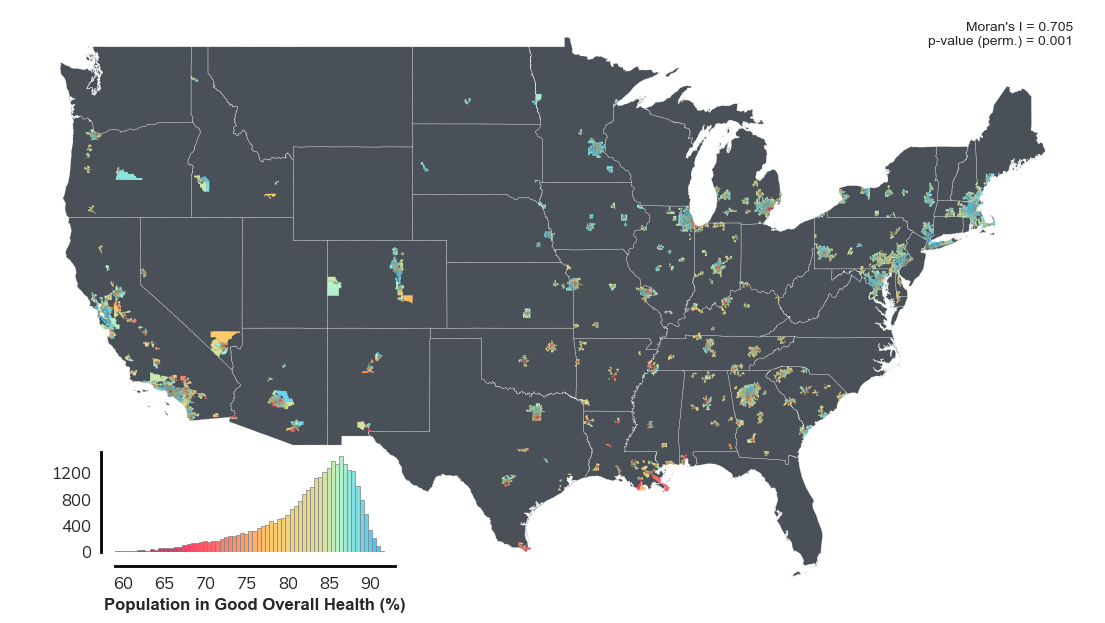

In [25]:
sns.set_style("white")
# For inset "cutouts"
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset

csfont = {'fontname':'Muli'}
color_list = ['#ff1b6b', '#ffcb6b', '#b6f3c9', '#45caff']
cmap = mcolors.LinearSegmentedColormap.from_list("my_color", color_list, N=100)

# Project to local crs
baseline_df_3857 = baseline_df.to_crs(epsg=3857)
usa_states_3857 = usa_states.to_crs(epsg=3857)
usa_bounds_3857 = usa_bounds.to_crs(epsg=3857)

# Compute spatial autocorrelation
target_col = "Composite Index"

# Construct spatial weights (Queen contiguity)
w = libpysal.weights.Queen.from_dataframe(baseline_df)

# Standardize weights (row-standardization, common practice)
w.transform = "r"

# Run Moran’s I
y = baseline_df[target_col].values
moran = Moran(y, w)

print("Moran's I:", moran.I)
print("Expected I:", moran.EI)
print("p-value (permutation test):", moran.p_sim)

fig, ax = plt.subplots(figsize=(14, 10))
usa_bounds_3857.plot(ax=ax, color='#495057', edgecolor='None')
usa_states_3857.plot(ax=ax, facecolor='None', edgecolor='white', linewidth=0.25, linestyle='dashed')
data = baseline_df_3857['Composite Index'].values
vmin = baseline_df_3857['Composite Index'].quantile(0.01)
vcenter = baseline_df_3857['Composite Index'].quantile(0.5)
vmax = baseline_df_3857['Composite Index'].quantile(0.99)
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

cs = baseline_df_3857.plot(
    column='Composite Index',
    ax=ax,
    edgecolor='None',
    cmap=cmap,
    norm=norm
)

# Turn off outer axes for the main map
ax.set_axis_off()

# Grab colorbar axis & adjust
cbar_ax = cs.get_figure().axes[-1]
cbar_ax.tick_params(labelsize=18)
cbar_ax.set_xlabel(cbar_ax.get_xlabel(), fontsize=20, labelpad=10, fontweight='bold')

# ----------------------------------------------------------------------
# 1) INSET BARCHART with bold, "disconnected" axes
# ----------------------------------------------------------------------
bins = np.arange(data.min(), data.max(), 0.5)
hist, edges = np.histogram(data, bins=bins)
hist_colors = cmap(norm(edges))

# Create an inset Axes for the histogram
hist_ax = plt.axes([0.2, 0.25, 0.2, 0.1], facecolor='None')  # (x0, y0, width, height)
hist_ax.bar(
    edges[:-1],
    hist,
    width=np.diff(edges),
    color=hist_colors[:-1],
    ec='grey',
    linewidth=0.5,
    align="edge"
)

# Example limits
hist_ax.set_xlim(59, 93)
hist_ax.set_xlabel('Population in Good Overall Health (%)', fontsize=12, fontweight='bold')

# Hide top/right spines
hist_ax.spines['right'].set_visible(False)
hist_ax.spines['top'].set_visible(False)

# BOLD & OFFSET the bottom and left spines
for spine in ['left', 'bottom']:
    hist_ax.spines[spine].set_linewidth(2)        # make thicker
    hist_ax.spines[spine].set_color('black')      # ensure black color
    # Offset outward by 10 points so there's a small gap from the data region
    hist_ax.spines[spine].set_position(('outward', 10))

# Increase tick density (or set fixed intervals)
hist_ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=5))
hist_ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=8))

ax.text(
    0.98, 0.98,
    f"Moran's I = {moran.I:.3f}\n"
    f"p-value (perm.) = {moran.p_sim:.3g}",
    transform=ax.transAxes,
    ha="right",
    va="top",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
)

plt.yticks(fontsize=12, **csfont)
plt.xticks(fontsize=12, **csfont)
# plt.savefig('../figures/spatial_distribution.png', dpi=600)
plt.show()


/var/folders/sl/b1w4bg0n63l4xh0kblz9m3br0000gp/T/ipykernel_47665/2734887967.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


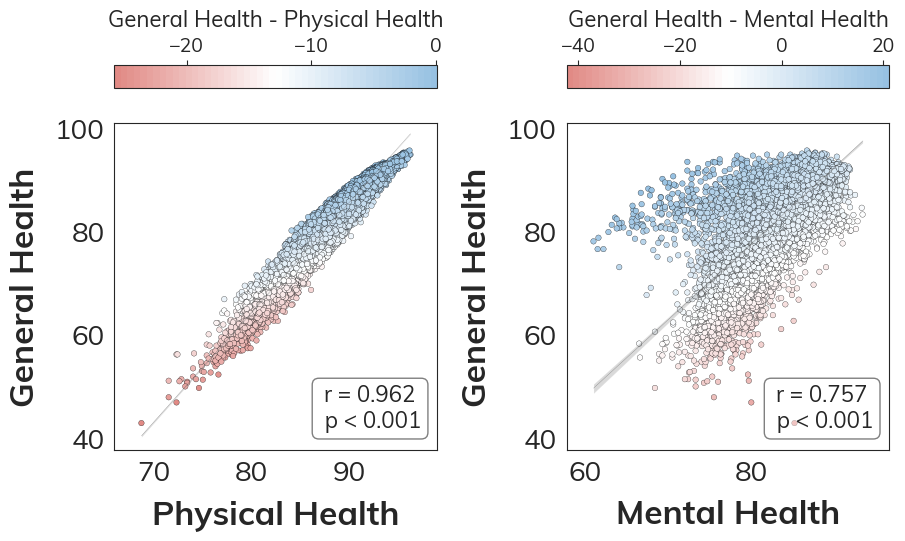

In [20]:
# -----------------------------------------------------------------------------
# Configure Matplotlib/Seaborn styles
# -----------------------------------------------------------------------------
plt.rcParams['font.family'] = 'Muli'
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

colors = ['#e18a85', '#ffffff', '#97c1e2']
cmap = mpl.colors.LinearSegmentedColormap.from_list("my_color", colors, N=50)

# -----------------------------------------------------------------------------
# Create the figure and GridSpec
# -----------------------------------------------------------------------------
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 2, figure=fig, hspace=0.2, wspace=0.4)  # 1 row, 3 cols

# Define pairs of columns to plot
column_pairs = [
    ("Physical Health", "General Health"),
    ("Mental Health", "General Health"),
    ("Mental Health", "Physical Health")
]

# -----------------------------------------------------------------------------
# Helper function to plot one pair of columns with a TOP colorbar
# -----------------------------------------------------------------------------

from scipy.stats import pearsonr

def scatter_regplot_with_corr(ax, df, x_col, y_col):
    # Scatter
    sc = ax.scatter(
        df[x_col],
        df[y_col],
        c=df[y_col] - df[x_col],
        s=16,
        edgecolors='black',
        linewidth=0.2,
        cmap=cmap
    )

    # Regression line
    sns.regplot(
        x=x_col,
        y=y_col,
        data=df,
        ci=99,
        scatter=False,
        color="black",
        line_kws={"linewidth": 0.1},
        ax=ax
    )

    # Pearson correlation
    r, p = pearsonr(df[x_col], df[y_col])
    if p < 0.001:
        sig = "***"
    elif p < 0.01:
        sig = "**"
    elif p < 0.05:
        sig = "*"
    else:
        sig = "ns"

    ax.text(
        0.95, 0.2,
        f"r = {r:.3f} \n p < 0.001",
        transform=ax.transAxes,
        fontsize=16,
        fontfamily='Muli',
        va='top',
        ha='right',
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.5, boxstyle='round')
    )

    # Limits
    x_min, x_max = df[x_col].min(), df[x_col].max()
    y_min, y_max = df[y_col].min(), df[y_col].max()
    x_pad = (x_max - x_min) * 0.1
    y_pad = (y_max - y_min) * 0.1
    ax.set_xlim(x_min - x_pad, x_max + x_pad)
    ax.set_ylim(y_min - y_pad, y_max + y_pad)

    # Labels
    ax.set_xlabel(x_col, fontfamily='Muli', fontsize=24, labelpad=10, fontweight='bold')
    ax.set_ylabel(y_col, fontfamily='Muli', fontsize=24, labelpad=10, fontweight='bold')
    ax.tick_params(axis='both', labelfontfamily='Muli', labelsize=20)
    ax.grid(False)

    # Top colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size="7%", pad=0.35)
    cb = fig.colorbar(sc, cax=cax, orientation='horizontal')
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')
    cb.ax.set_xlabel(f"{y_col} - {x_col}", labelpad=8, fontsize=16)
    cb.ax.tick_params(labelsize=14)


# -----------------------------------------------------------------------------
# Draw the three subplots
# -----------------------------------------------------------------------------
for i, (x_col, y_col) in enumerate(column_pairs):
    if i == 2:
        continue
    ax = fig.add_subplot(gs[0, i])
    scatter_regplot_with_corr(ax, baseline_df, x_col, y_col)

plt.tight_layout()
# plt.savefig('../figures/linear_health_associations_top_cbar.pdf', dpi=300, bbox_inches='tight')
plt.show()


General || Physical: KS = 0.383, p < 0.001 
General || Mental: KS = 0.200, p < 0.001 
Physical || Mental: KS = 0.581, p < 0.001 



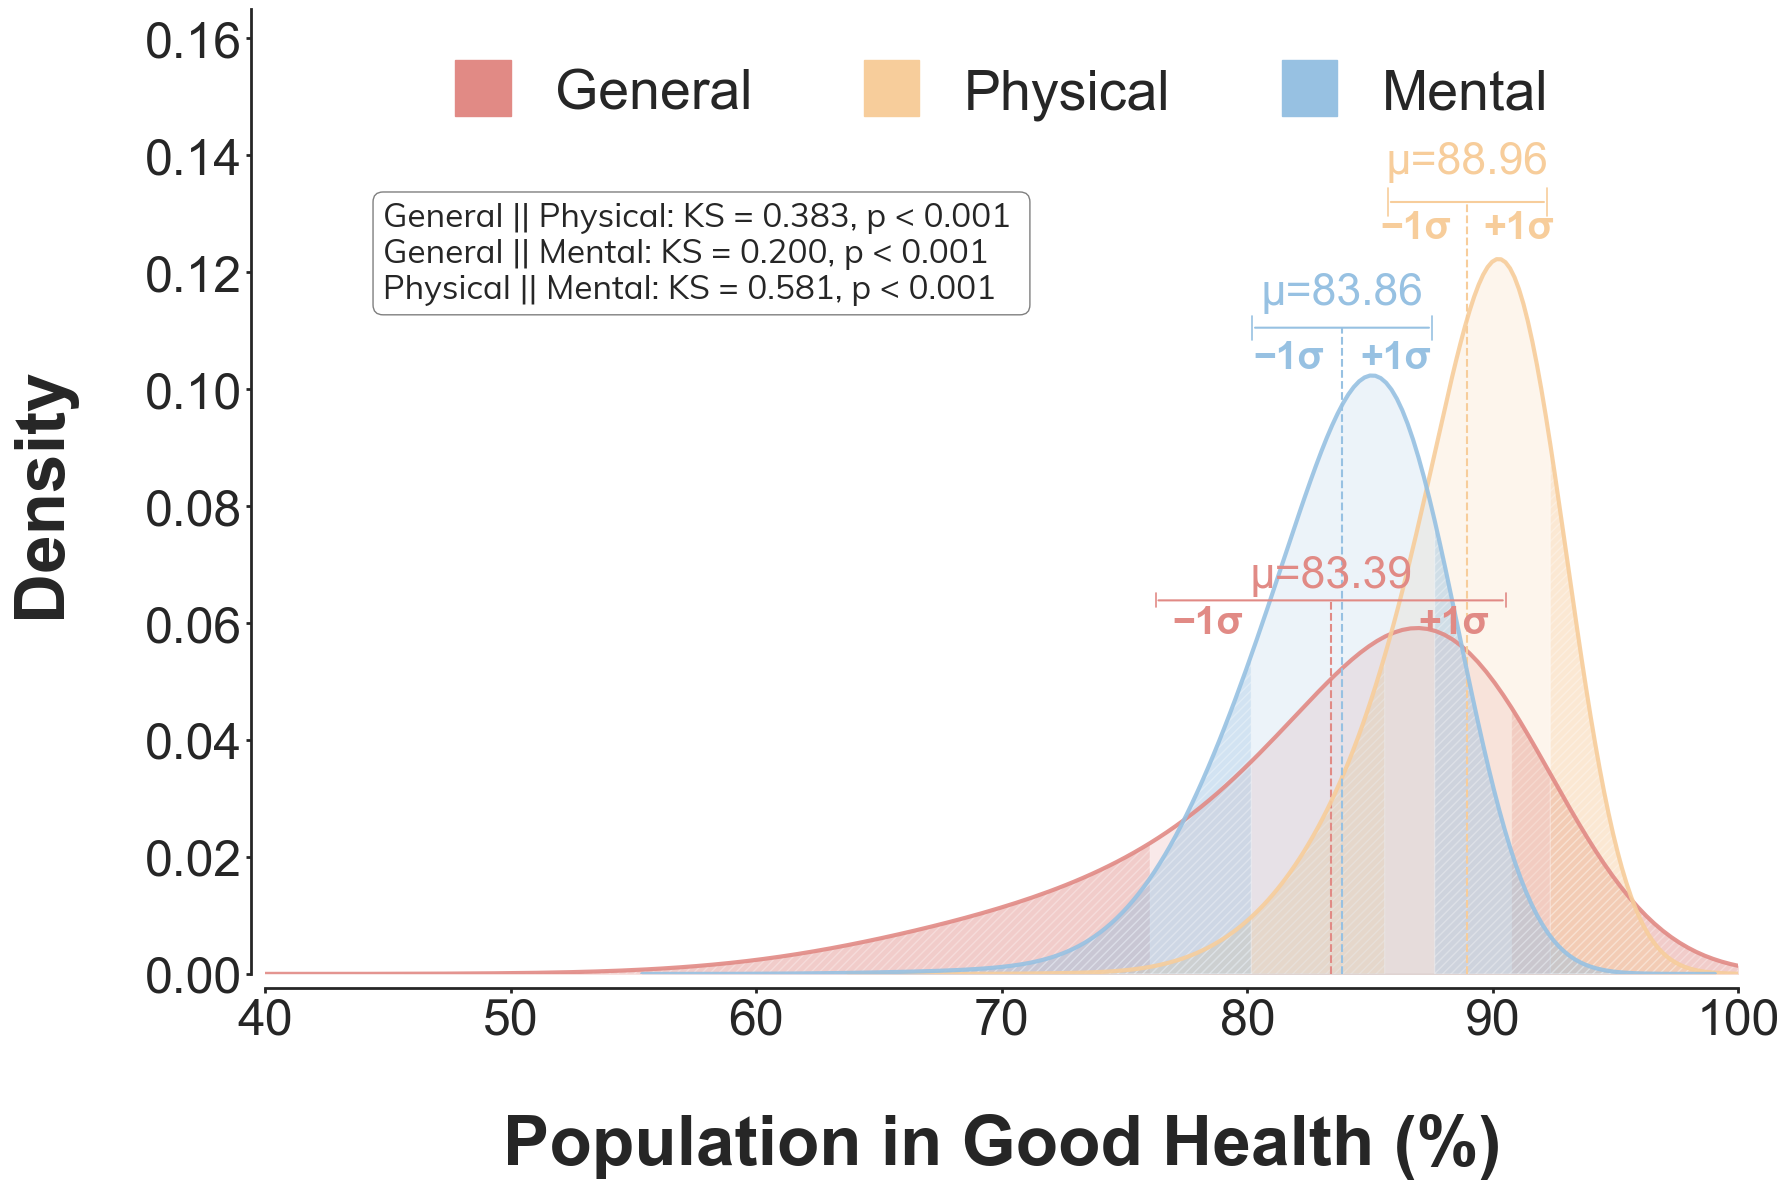

In [29]:
plt.rcParams['font.family'] = 'Muli'
plt.rcParams.update({
    'legend.fontsize': 22,
    'legend.handlelength': 1.5,
})

target_cols = ['General Health', 'Physical Health', 'Mental Health']
colnames = [
    "General Health",
    "Physical Health",
    "Mental Health"
]
colors = ['#e18a85', '#f7cd9b', '#97c1e2']

sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(18, 12))

max_y = 0.0
densities = {}

# KDE + plot each variable
for i in range(3):
    series = pd.to_numeric(baseline_df[target_cols[i]], errors='coerce').dropna()
    if series.nunique() < 2:
        continue

    x_vals = series.values
    N = len(x_vals)
    mean_value = np.mean(x_vals)
    std = np.std(x_vals)

    # KDE line
    kde_ax = sns.kdeplot(
        x=x_vals, ax=ax, color=colors[i],
        bw_adjust=4, clip=(0, 100), lw=3, alpha=0.9
    )
    line = kde_ax.lines[-1]
    x = line.get_xdata()
    y = line.get_ydata()
    ymax = y.max()
    max_y = max(max_y, ymax)

    # Store densities on common grid for KL
    grid = np.linspace(40, 100, 500)
    y_interp = np.interp(grid, x, y)
    y_norm = y_interp / np.trapz(y_interp, grid)
    densities[target_cols[i]] = y_norm

    # Soft fill
    ax.fill_between(x, y, 0, color=colors[i], alpha=0.18)

    # Shade tails beyond ±1σ
    ax.fill_between(x, y, where=(x <= mean_value - std), color=colors[i],
                    alpha=0.3, hatch='////', edgecolor='white')
    ax.fill_between(x, y, where=(x >= mean_value + std), color=colors[i],
                    alpha=0.3, hatch='////', edgecolor='white')

    # Mean vertical line
    ax.vlines(mean_value, ymin=0, ymax=ymax * 1.08,
              color=colors[i], linestyle='--', linewidth=1.5)

    # Bracket for ±1σ
    ax.annotate("", xy=(mean_value - std, ymax * 1.08),
                xytext=(mean_value + std, ymax * 1.08),
                arrowprops=dict(arrowstyle="-", color=colors[i], linewidth=1.5))
    ax.plot([mean_value - std, mean_value - std], [ymax * 1.06, ymax * 1.10],
            color=colors[i], linewidth=1.2)
    ax.plot([mean_value + std, mean_value + std], [ymax * 1.06, ymax * 1.10],
            color=colors[i], linewidth=1.2)

    # Labels
    ax.text(mean_value, ymax * 1.12, f'μ={mean_value:.2f}',
            color=colors[i], fontsize=32, ha='center', fontweight='regular')

    if i == 0:
        ax.text(mean_value - std/2, ymax * 1.12 - 0.008, '−1σ',
            color=colors[i], fontsize=28, ha='right', fontweight='bold')
        ax.text(mean_value + std/2, ymax* 1.12  - 0.008, '+1σ',
                color=colors[i], fontsize=28, ha='left', fontweight='bold')
    else:
        ax.text(mean_value - std/5, ymax* 1.12 - 0.011, '−1σ',
                color=colors[i], fontsize=28, ha='right', fontweight='bold')
        ax.text(mean_value + std/5, ymax* 1.12 - 0.011, '+1σ',
                color=colors[i], fontsize=28, ha='left', fontweight='bold')

# --- KL divergence calculations ---
pairs = [
    ("General Health", "Physical Health"),
    ("General Health", "Mental Health"),
    ("Physical Health", "Mental Health")
]

annot_text = ""
for a, b in pairs:
    stat, p = ks_2samp(baseline_df[a].dropna(), baseline_df[b].dropna())
    annot_text += (f"{a.split()[0]} || {b.split()[0]}: KS = {stat:.3f}, p < 0.001 \n")

print(annot_text)
ax.text(
    0.08, 0.8,
    annot_text[:-2],
    transform=ax.transAxes,
    fontsize=24,
    fontfamily='Muli',
    va='top',
    ha='left',
    bbox=dict(facecolor='white', edgecolor='black', alpha=0.5, boxstyle='round')
)

# Axis styling
ax.set_xlim(40, 100)
ax.set_ylim(top=max_y * 1.35)
ax.set_ylabel('Density', fontsize=50, fontweight='bold', labelpad=50,)
ax.set_xlabel('Population in Good Health (%)', fontsize=50, labelpad=50, fontweight='bold')

ax.tick_params(axis='x', labelsize=36, width=2)
ax.tick_params(axis='y', labelsize=36, width=2)

sns.despine(ax=ax, offset=10)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

legend_patches = [
    mpatches.Patch(color='#e18a85', label='General'),
    mpatches.Patch(color='#f7cd9b', label='Physical'),
    mpatches.Patch(color='#97c1e2', label='Mental')
]

leg = ax.legend(handles=legend_patches, loc='upper center',
                handlelength=1, bbox_to_anchor=(0.5, 0.99),
                ncol=4, frameon=False, fontsize=40)

for patch in leg.get_patches():
    patch.set_height(40)
    patch.set_y(-5)

plt.tight_layout()
# plt.savefig('../figures/health_dist.pdf', dpi=300)
plt.show()


Index(['High minority (>=30%)', 'Low minority (<30%)'], dtype='object', name='minority_classification')
Index(['High Poverty (>=20%)', 'Low Poverty (<20%)'], dtype='object', name='poverty_classification')
Index(['Rural (<2500)', 'Urban (>=2500)'], dtype='object', name='urban_rural_classification')
Index(['Aged (>=14%)', 'Ageing (<14%)'], dtype='object', name='aged_classification')


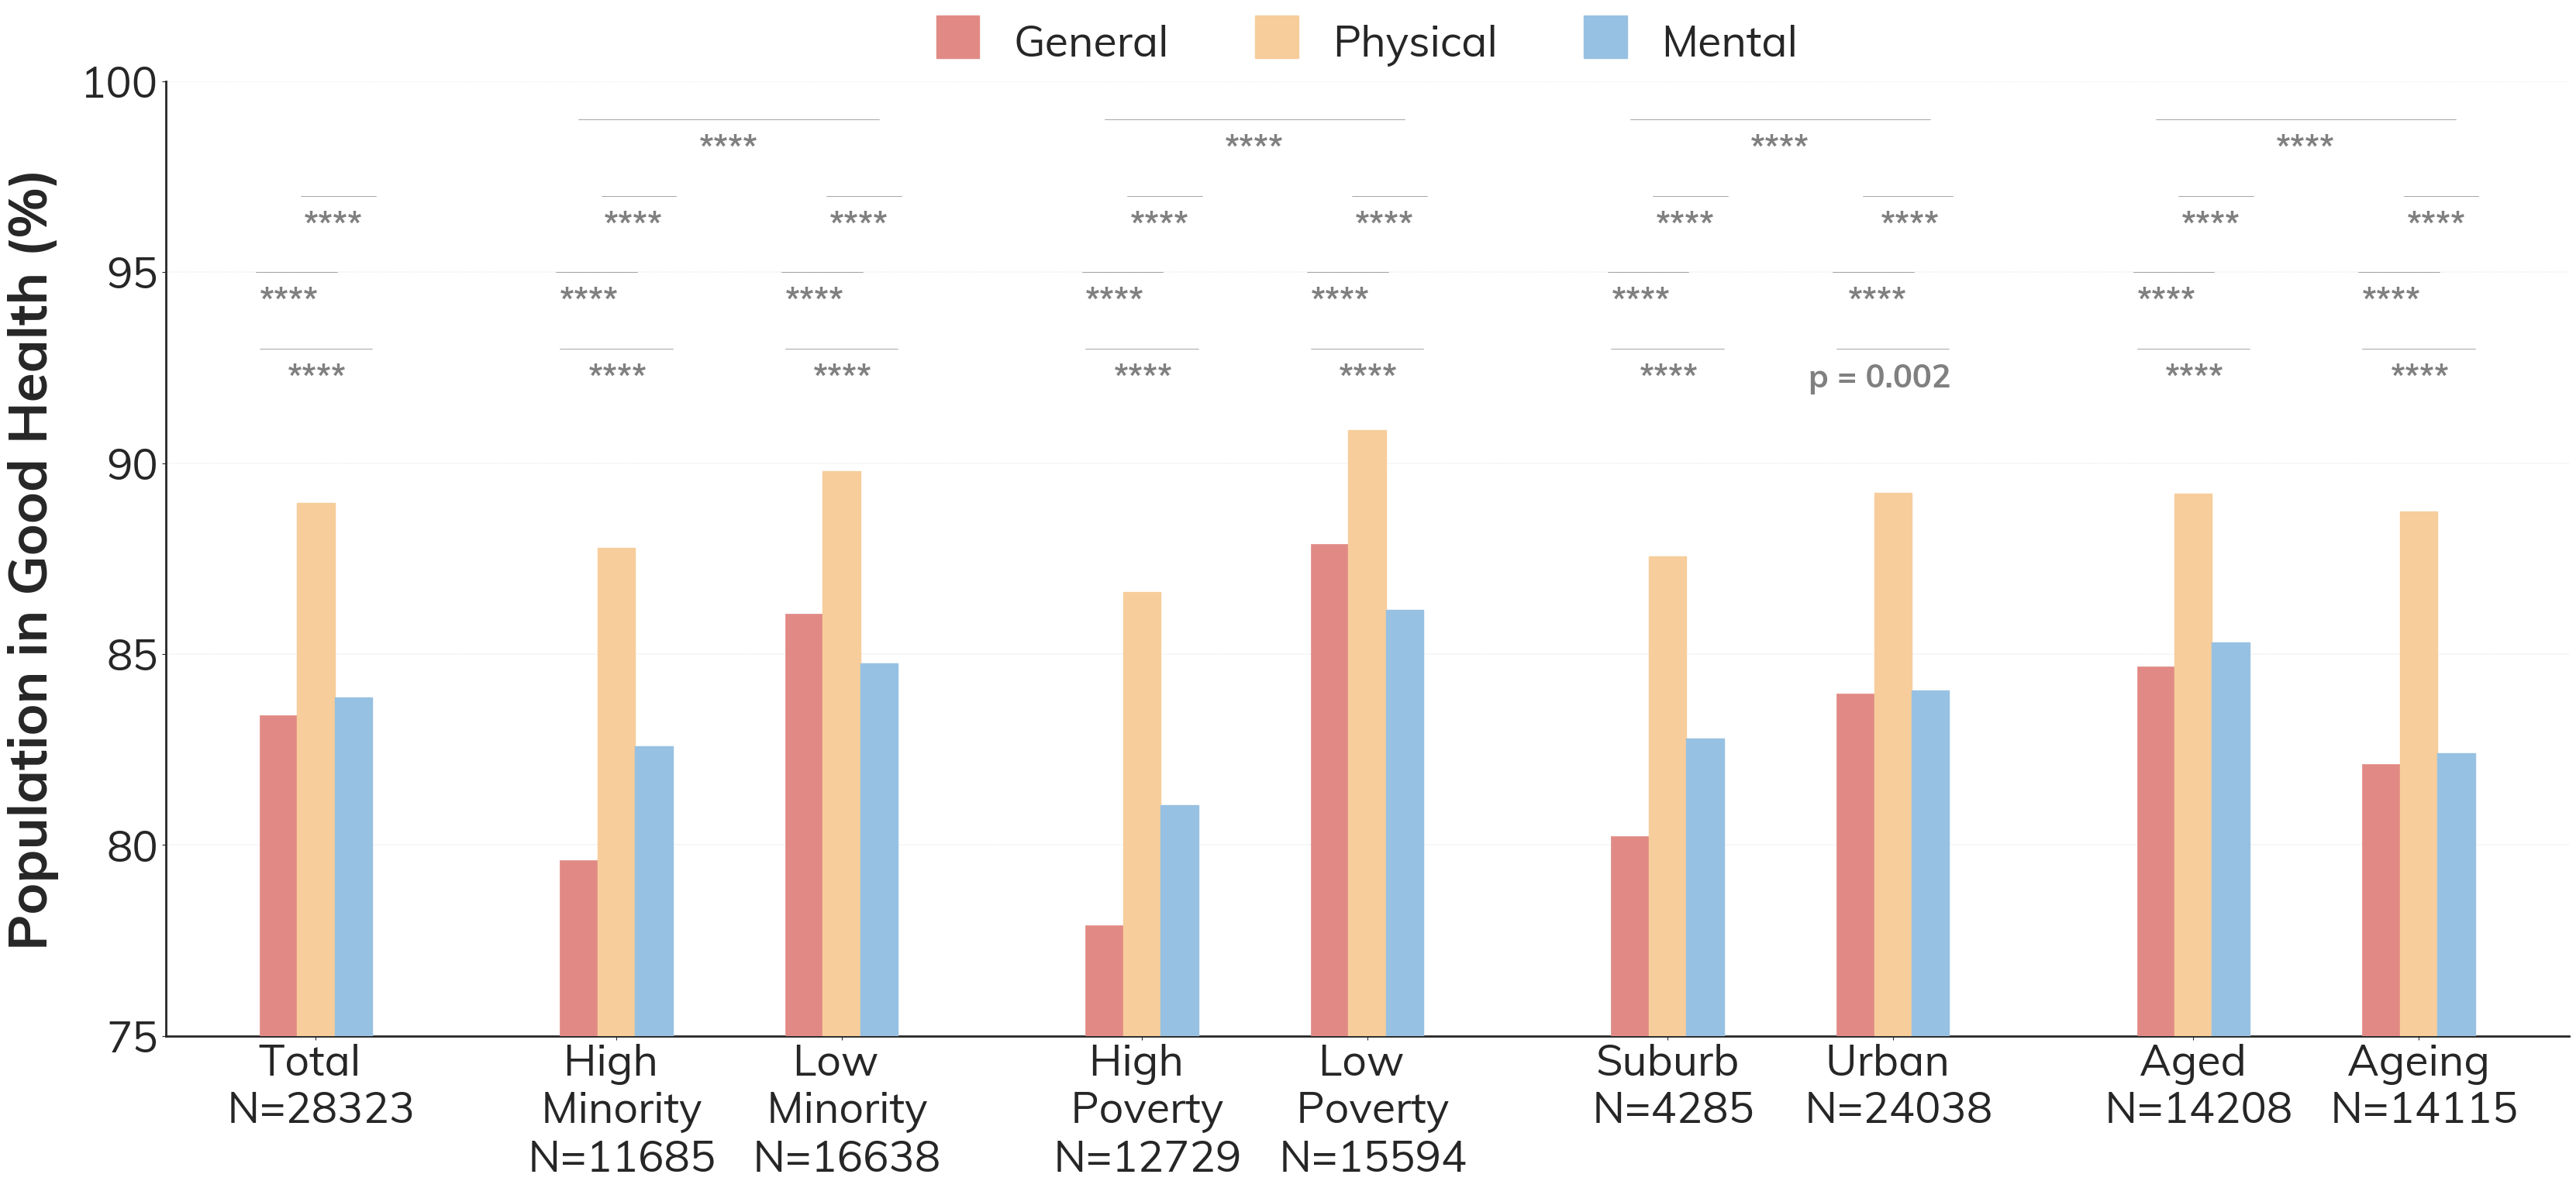

In [35]:
wellbeing_cols = ['General Health', 'Physical Health','Mental Health']

# High poverty 20% or more - https://www.ers.usda.gov/data-products/poverty-area-measures/
baseline_df['poverty_classification'] = baseline_df['Proportion of persons below 150 percent poverty threshold'].apply(lambda x: 'Low Poverty (<20%)' if x < 20 else 'High Poverty (>=20%)')
baseline_df.groupby(['poverty_classification'])[wellbeing_cols].aggregate('mean')

# https://www.census.gov/newsroom/blogs/random-samplings/2022/12/redefining-urban-areas-following-2020-census.html
baseline_df['urban_rural_classification'] = baseline_df['Total Population'].apply(lambda x: 'Rural (<2500)' if x < 2500 else 'Urban (>=2500)')

# Minority census tract - https://www.fhfa.gov/data/underserved-areas-data
baseline_df['minority_classification'] = baseline_df['Percentage of minority race'].apply(lambda x: 'Low minority (<30%)' if x < 30 else 'High minority (>=30%)')

# https://www.oecd-ilibrary.org/docserver/f7ebe745-en.pdf?expires=1731206775&id=id&accname=guest&checksum=4C0D048820138AB9558F4ECC18F91C1B#:~:text=In%20this%20report%2C%20we%20qualify,share%20is%2021%25%20or%20higher.baseline_df['aged_classification'] = baseline_df['Proportion of persons aged 65 and above'].apply(lambda x: 'Minority' if x < 14 else 'Non-minority')
baseline_df['aged_classification'] = baseline_df['Proportion of persons aged 65 and above'].apply(lambda x: 'Ageing (<14%)' if x < 14 else 'Aged (>=14%)')

group_a = baseline_df[baseline_df['poverty_classification'] == 'Low Poverty (<20%)']['General Health'].values
group_b = baseline_df[baseline_df['poverty_classification'] == 'High Poverty (>=20%)']['General Health'].values

t_stat, p_value = stats.ttest_ind(group_a, group_b)

# Compute means and stds
mean_gen, mean_phy, mean_men = baseline_df[wellbeing_cols].mean(axis=0)
std_gen, std_phy, std_men = baseline_df[wellbeing_cols].std(axis=0)

# Generate combinations for plotting pairs
combinations = list(itertools.combinations(wellbeing_cols, 2))

def return_means_and_stds(baseline_df, column, wellbeing_cols):

    print(baseline_df.groupby([column])[wellbeing_cols].aggregate('mean').index)
    counts_dict = dict(baseline_df[column].value_counts())
    mean_high_poverty_gen, mean_high_poverty_phy, mean_high_poverty_men = baseline_df.groupby([column])[wellbeing_cols].aggregate('mean').iloc[[0]].values[0]
    mean_low_poverty_gen, mean_low_poverty_phy, mean_low_poverty_men = baseline_df.groupby([column])[wellbeing_cols].aggregate('mean').iloc[[1]].values[0]

    std_high_poverty_gen, std_high_poverty_phy, std_high_poverty_men = baseline_df.groupby([column])[wellbeing_cols].aggregate('std').iloc[[0]].values[0]
    std_low_poverty_gen, std_low_poverty_phy, std_low_poverty_men = baseline_df.groupby([column])[wellbeing_cols].aggregate('std').iloc[[1]].values[0]

    value_list = [mean_high_poverty_gen, mean_high_poverty_phy, mean_high_poverty_men,
                      std_high_poverty_gen, std_high_poverty_phy, std_high_poverty_men,
                      mean_low_poverty_gen, mean_low_poverty_phy, mean_low_poverty_men,
                      std_low_poverty_gen, std_low_poverty_phy, std_low_poverty_men]
    
    subset_a, subset_b = list(baseline_df[column].value_counts().keys())

    combinations = list(itertools.combinations(wellbeing_cols, 2))

    for col in wellbeing_cols:
        group_a = baseline_df[baseline_df[column] == subset_a][col].values
        group_b = baseline_df[baseline_df[column] == subset_b][col].values
        globals()[f'{col.split(" ")[0]}_t_stat'], globals()[f'{col.split(" ")[0]}_p_value'] = stats.ttest_ind(group_a, group_b)
        value_list.append(globals()[f'{col.split(" ")[0]}_t_stat'])
        value_list.append(globals()[f'{col.split(" ")[0]}_p_value'])
    

    group_df_1 = baseline_df[baseline_df[column] == subset_a][wellbeing_cols]
    group_df_1_results = {}
    for i in combinations:
        t_stat, p_value = stats.ttest_rel(group_df_1[i[0]], group_df_1[i[1]])
        group_df_1_results[i] = {'t_stat': t_stat, 'p_val': p_value, 'cat': subset_a}


    group_df_2 = baseline_df[baseline_df[column] == subset_b][wellbeing_cols]
    group_df_2_results = {}
    for i in combinations:
        t_stat, p_value = stats.ttest_rel(group_df_2[i[0]], group_df_2[i[1]])
        group_df_2_results[i] = {'t_stat': t_stat, 'p_val': p_value, 'cat': subset_b}

    value_list.append(group_df_1_results)
    value_list.append(group_df_2_results)
    value_list.append(counts_dict)

    return value_list

minority_list = return_means_and_stds(baseline_df, 'minority_classification', wellbeing_cols)
poverty_list = return_means_and_stds(baseline_df, 'poverty_classification', wellbeing_cols)
urban_rural_list = return_means_and_stds(baseline_df, 'urban_rural_classification', wellbeing_cols)
aged_list = return_means_and_stds(baseline_df, 'aged_classification', wellbeing_cols)

plt.rcParams['font.family'] = 'Muli'
params = {'legend.fontsize': 40,
          'legend.handlelength': 1}
plt.rcParams.update(params)
# Sample data
colors_group2 = ['#e18a85'] * 3
colors_group3 = ['#f7cd9b'] * 3
colors_group4 = ['#97c1e2'] * 3

categories = [f'Total \n N=28323', 
              f'High \n Minority\n N={int(round(list(minority_list[-1].values())[1]))}', 
              f'Low \n Minority\n N={int(round(list(minority_list[-1].values())[0]))}',
              f'High \n Poverty\n N={int(round(list(poverty_list[-1].values())[1]))}', 
              f'Low \n Poverty\n N={int(round(list(poverty_list[-1].values())[0]))}',
              f'Suburb\n N={int(round(list(urban_rural_list[-1].values())[1]))}', 
              f'Urban \n N={int(round(list(urban_rural_list[-1].values())[0]))}', 
              f'Aged\n N={int(round(list(aged_list[-1].values())[0]))}', 
              f'Ageing\n N={int(round(list(aged_list[-1].values())[1]))}']
groups = ['Total', 'Minority\nRatio', 'Poverty\nRatio', 'Urban-\nSuburban', 'Agedness']
group1 = [mean_gen, minority_list[0] ,minority_list[6], poverty_list[0],poverty_list[6],  urban_rural_list[0],urban_rural_list[6],  aged_list[0],aged_list[6]]
group2 = [mean_phy, minority_list[1], minority_list[7], poverty_list[1],poverty_list[7],  urban_rural_list[1],urban_rural_list[7],  aged_list[1],aged_list[7]]
group3 = [mean_men, minority_list[2], minority_list[8], poverty_list[2],poverty_list[8],  urban_rural_list[2],urban_rural_list[8],  aged_list[2],aged_list[8]]

# X locations for the groups
x = np.array([0.2, 0.6,0.9, 1.3, 1.6, 2.0,2.3,2.7,3.0])
x_pos = np.array([0.2, 0.75, 1.45, 2.15, 2.85])

# Bar width
# margins = 0.05
width = 0.05

# Plotting
fig, ax = plt.subplots(figsize=(40,16))
bar1 = ax.bar(x - width, group1, width, color = colors_group2, edgecolor='#e18a85', linewidth=0.5, label='General', zorder=3)
bar2 = ax.bar(x, group2, width, color = colors_group3, label='Physical',zorder=3, edgecolor='#f7cd9b')
bar3 = ax.bar(x + width, group3, width, color = colors_group4, label='Mental', zorder=3, edgecolor='#97c1e2')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

# Labels and title
# ax.set_xlabel('Categories', fontsize=14, labelpad=20)
ax.set_ylabel('Population in Good Health (%)', fontsize=50, labelpad=20, fontweight='bold')
ax.set_xticks(x)
ax.set_xlim((0,3.2))
ax.set_ylim((75,100))
ax.set_xticklabels(categories)
ax.tick_params(axis='x', labelsize=40, labelfontfamily='Muli')  # Adjust x-axis tick font size
ax.tick_params(axis='y', labelsize=40, labelfontfamily='Muli')  # Adjust y-axis tick font size


legend_patches = [
    mpatches.Patch(color='#e18a85', label='General'),
    mpatches.Patch(color='#f7cd9b', label='Physical'),
    mpatches.Patch(color='#97c1e2', label='Mental')
]

for i in x:
    if i == 2.3:
        # Add bracket edges
        gap = 0.075
        height = 93
        ax.plot([i - gap, i+gap], [height, height], color='grey', linewidth=0.5)
        ax.text(i-gap*1.5, height-1, f'p = 0.002', color='grey', fontsize=30, fontweight='bold')

        gap2 = 0.04
        height2 = 95
        ax.plot([i - gap2*2, i+gap2*0.7], [height2, height2], color='grey', linewidth=0.5)
        ax.text(i-gap*0.8, height+1, f'****', color='grey', fontsize=30, fontweight='bold')

        gap3 = 0.04
        height3 = 97
        ax.plot([i - gap3, i+gap3*2], [height3, height3], color='grey', linewidth=0.5)
        ax.text(i-gap3*0.4, height3-1, f'****', color='grey', fontsize=30, fontweight='bold')
    else:
        # Add bracket edges
        gap = 0.075
        height = 93
        ax.plot([i - gap, i+gap], [height, height], color='grey', linewidth=0.5)
        ax.text(i-gap/2, height-1, f'****', color='grey', fontsize=30, fontweight='bold')

        gap2 = 0.04
        height2 = 95
        ax.plot([i - gap2*2, i+gap2*0.7], [height2, height2], color='grey', linewidth=0.5)
        ax.text(i-gap, height+1, f'****', color='grey', fontsize=30, fontweight='bold')

        gap3 = 0.04
        height3= 97
        ax.plot([i - gap3*0.5, i+gap3*2], [height3, height3], color='grey', linewidth=0.5)
        ax.text(i-gap3*0.4, height3-1, f'****', color='grey', fontsize=30, fontweight='bold')
    # ax.annotate(
    #     "", xy=(i + 0.05, 96), 
    #     xytext=(i + 0.05, 101), 
    #     arrowprops=dict(arrowstyle="-", color='grey', linewidth=0.5)
    # )
for i in x_pos:
    if i == 0.2:
        pass
    else:
        gap = 0.2
        height = 99
        ax.plot([i - gap, i+gap], [height, height], color='grey', linewidth=0.5, clip_on=False)
        ax.text(i-gap*0.2, height-1, f'****', color='grey', fontsize=30, fontweight='bold')

ax.axhline(y=80, color='grey', linestyle='--', linewidth=0.3, alpha=0.4, zorder=-1)
ax.axhline(y=85, color='grey', linestyle='--', linewidth=0.3, alpha=0.4, zorder=-1)

ax.axhline(y=90, color='grey', linestyle='--', linewidth=0.3, alpha=0.4, zorder=-1)
ax.axhline(y=95, color='grey', linestyle='--', linewidth=0.3, alpha=0.4, zorder=-1)

ax.axhline(y=100, color='grey', linestyle='--', linewidth=0.3, alpha=0.4, zorder=-1)

# Position legend at the top
leg = ax.legend(handles=legend_patches, loc='upper center', handlelength=1, bbox_to_anchor=(0.5, 1.1), ncol=4, frameon=False)

for patch in leg.get_patches():
    patch.set_height(40)
    patch.set_y(-2)

# Display the plot

# plt.savefig('../figures/comparison_distribution.pdf', dpi=300)
plt.show()


### Circular plots

In [58]:
general_df_sorted = pd.read_parquet('../data/general_feature_importance.parquet')
physical_df_sorted = pd.read_parquet('../data/physical_feature_importance.parquet')
mental_df_sorted = pd.read_parquet('../data/mental_feature_importance.parquet')

In [50]:
def get_label_rotation(angle, offset):
    # Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"
    return rotation, alignment

def add_labels(angles, values, labels, offset, ax, to_bold):
    
    # This is the space between the end of the bar and the label
    padding = 10

    # Iterate over angles, values, and labels, to add all of them.
    for angle, value, label, in zip(angles, values, labels):
        angle = angle
        
        # Obtain text rotation and alignment
        rotation, alignment = get_label_rotation(angle, offset)

        if label in to_bold:
            # And finally add the text
            ax.text(
                x=angle, 
                y=value + padding, 
                s=label, 
                ha=alignment, 
                va="center", 
                fontsize=30,
                fontfamily='Muli',
                fontweight='black',
                rotation=rotation, 
                rotation_mode="anchor"
            ) 
        else:
            # And finally add the text
            ax.text(
                x=angle, 
                y=value + padding, 
                s=label, 
                ha=alignment, 
                va="center", 
                fontsize=30,
                fontfamily='Muli',
                rotation=rotation, 
                rotation_mode="anchor"
            ) 

In [59]:
target_cols = ['General Health', 'Physical Health', 'Mental Health']
all_df_sorted = [general_df_sorted, physical_df_sorted, mental_df_sorted]

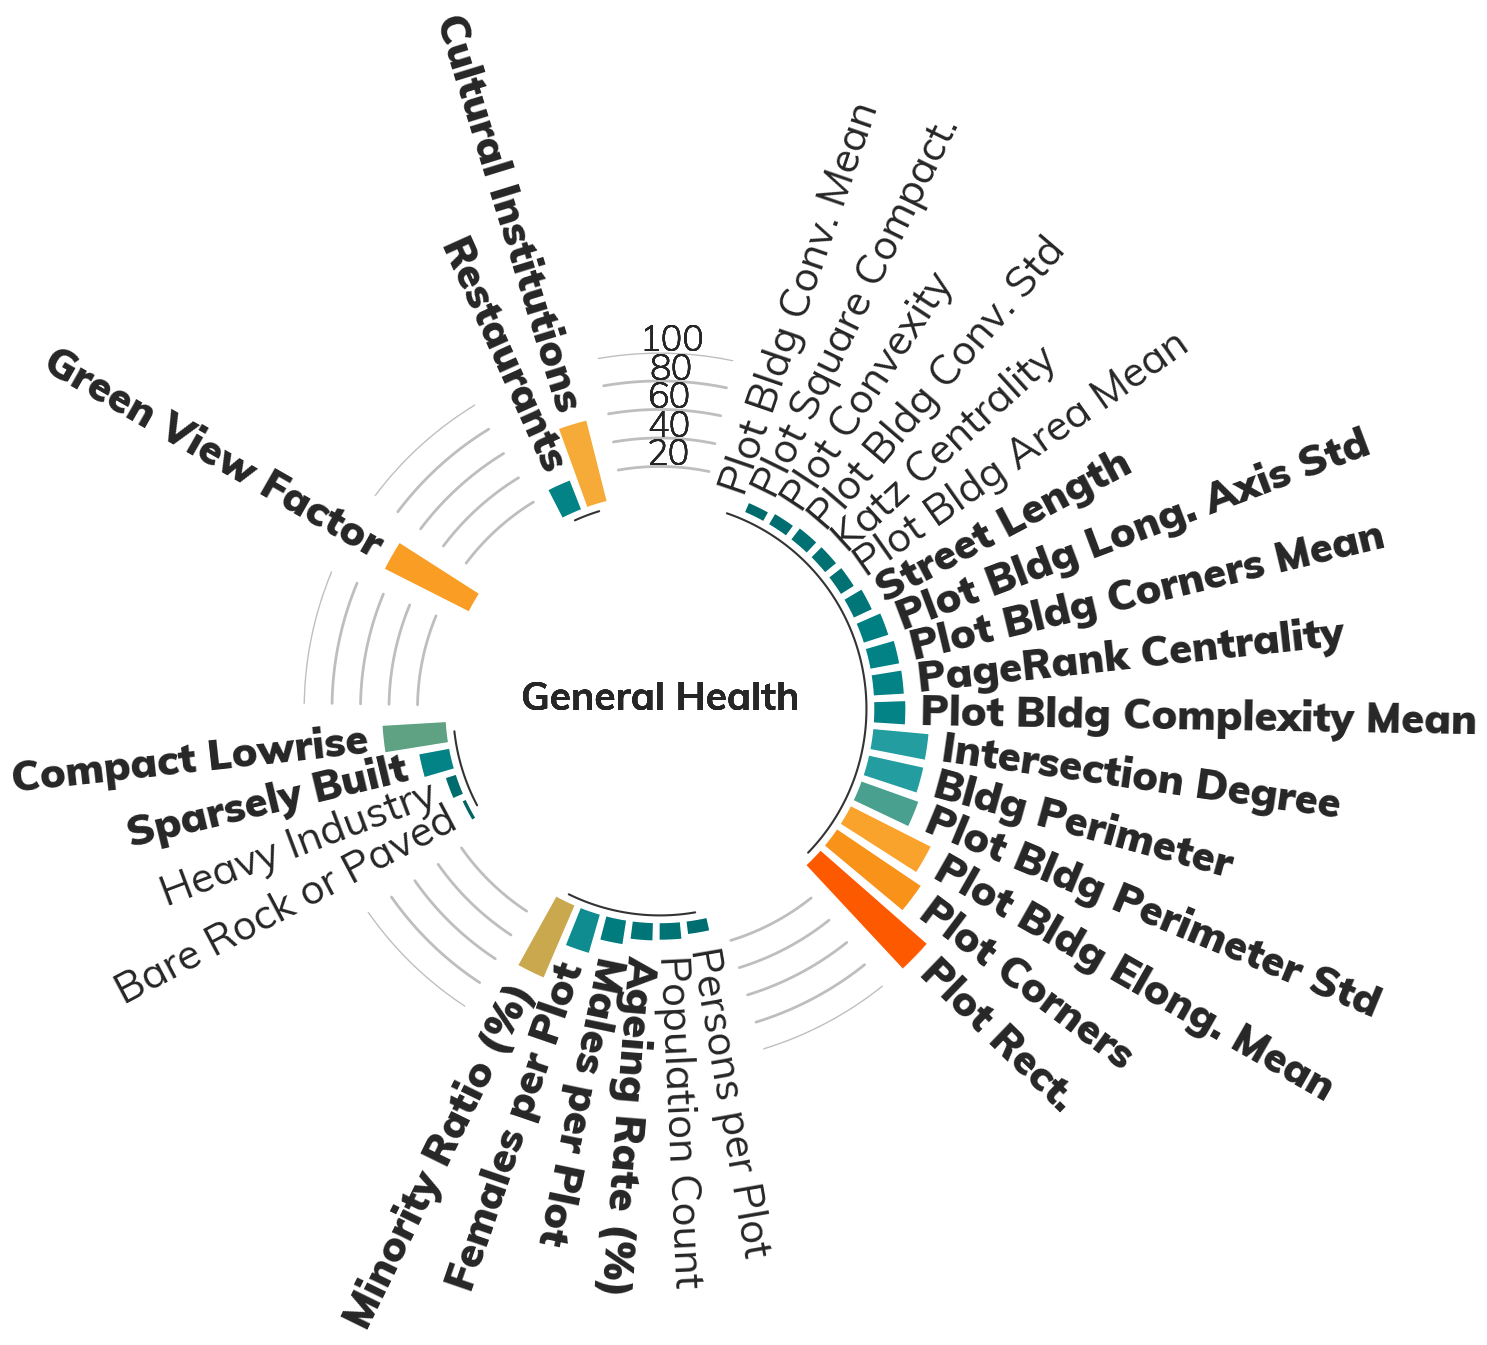

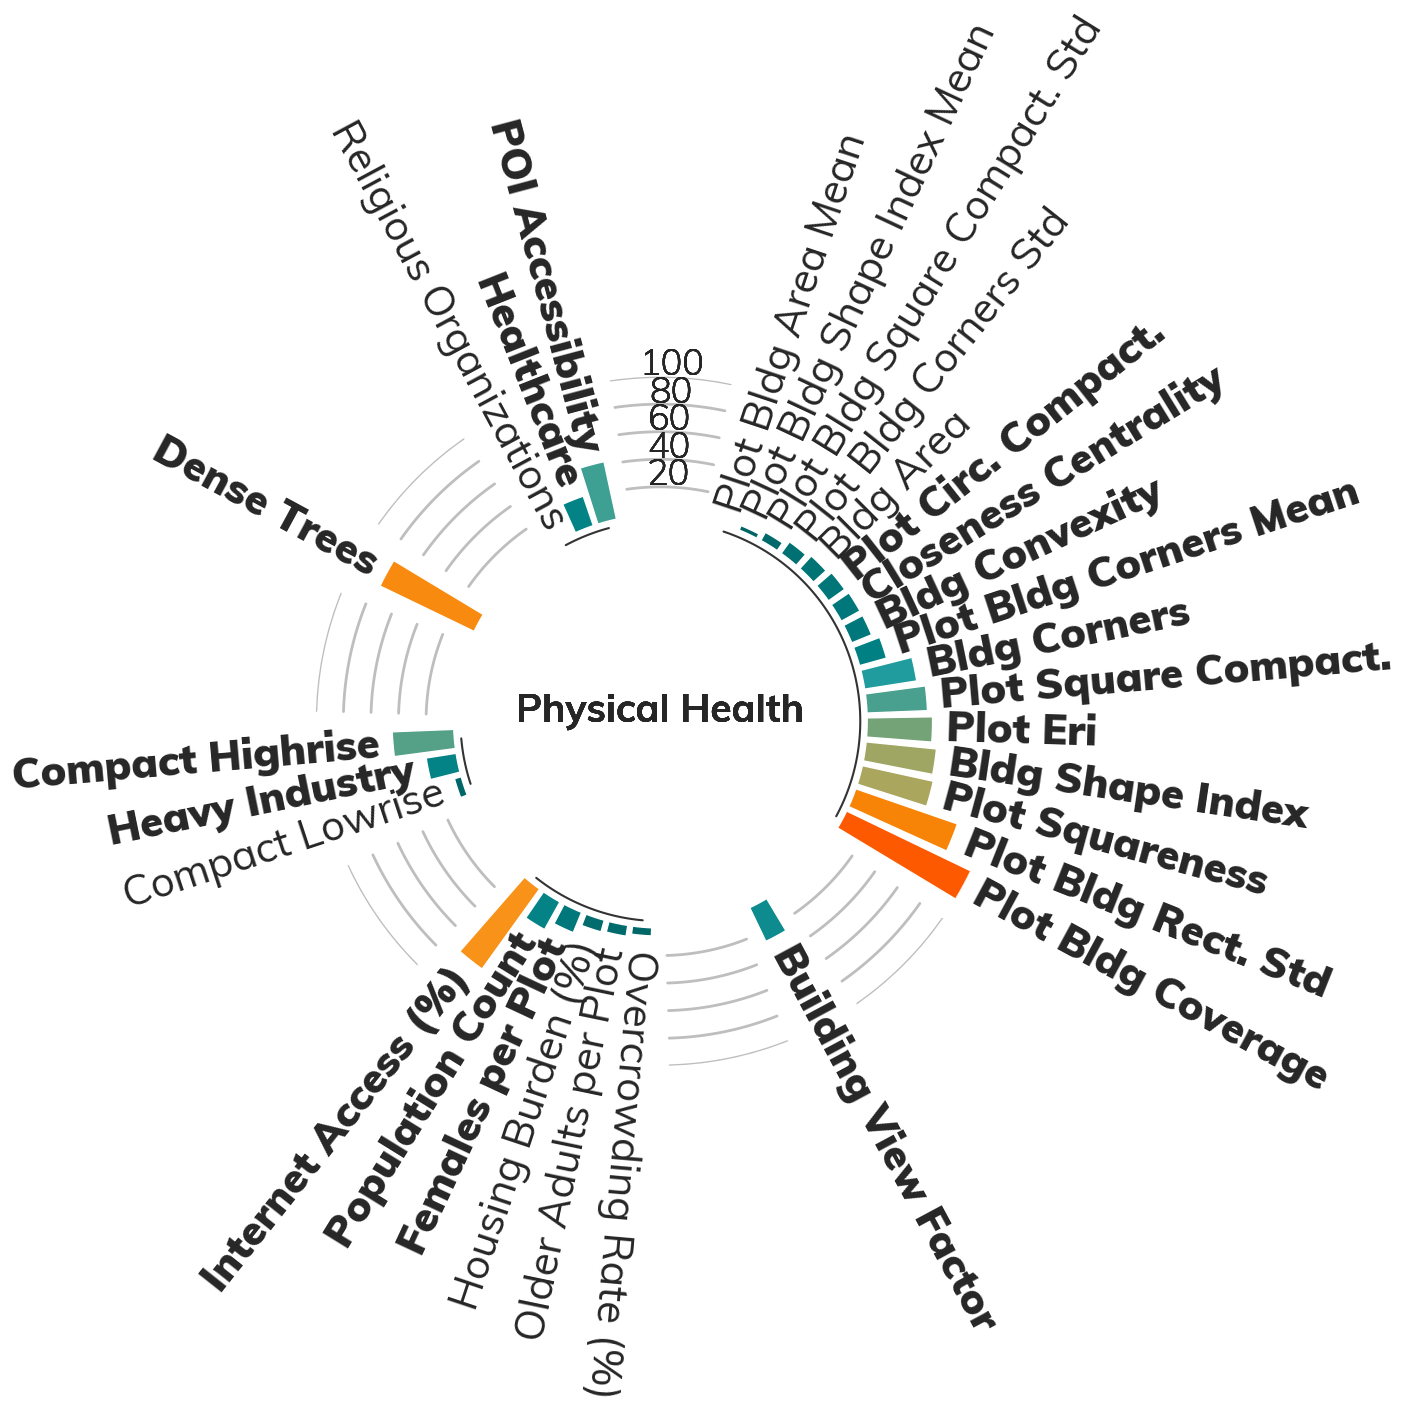

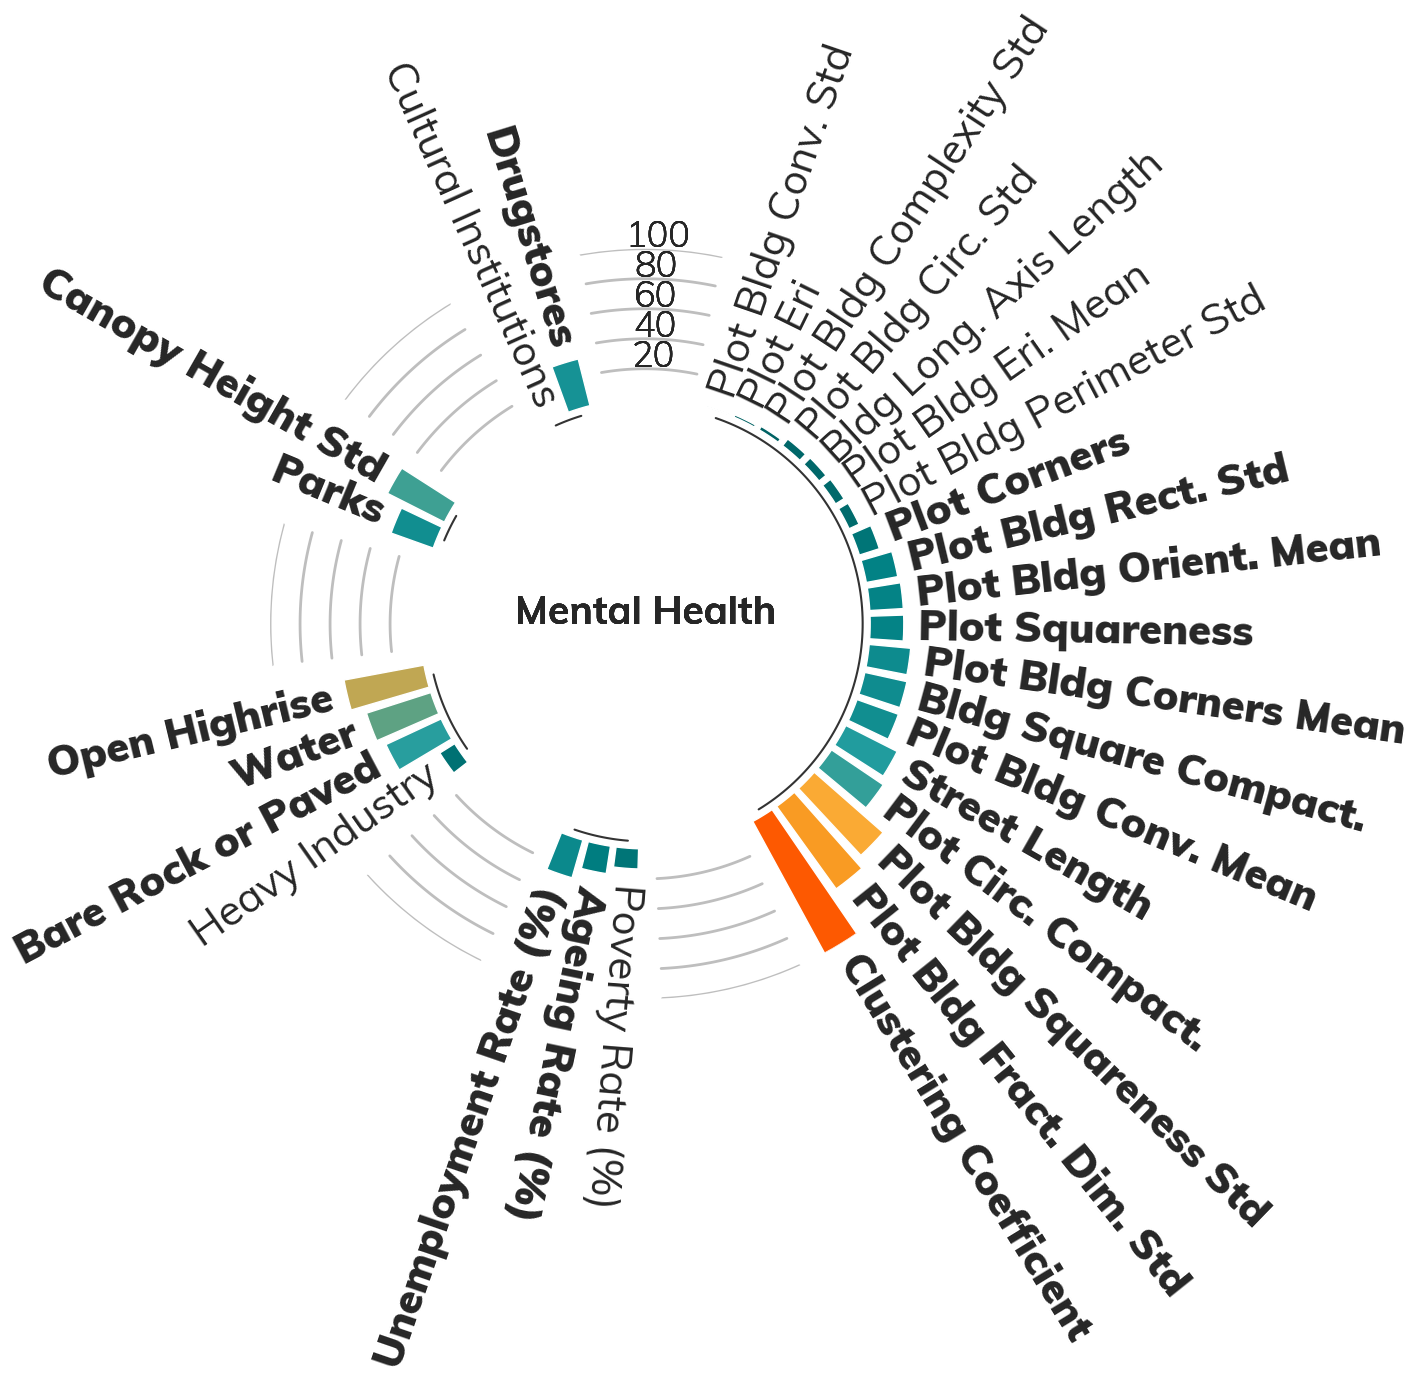

In [ ]:
for target_col, df_sorted in zip(target_cols, all_df_sorted):

    ANGLES = np.linspace(0, 2 * np.pi, len(df_sorted), endpoint=False)
    VALUES = df_sorted["importance"].values * 100
    LABELS = df_sorted["variable"].values

    OFFSET = np.pi / 2.3
    # Grab the group values
    GROUP = df_sorted["Category"].values

    # Add three empty bars to the end of each group
    PAD = 4
    ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
    ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
    WIDTH = (2 * np.pi) / len(ANGLES) *0.8

    # Obtain size of each group
    GROUPS_SIZE = [len(i[1]) for i in df_sorted.groupby("Category")]

    # Obtaining the right indexes is now a little more complicated
    offset = 0
    IDXS = []
    for size in GROUPS_SIZE:
        IDXS += list(range(offset + PAD, offset + size + PAD))
        offset += size + PAD

    # Same layout as above
    fig, ax = plt.subplots(figsize=(20, 13), subplot_kw={"projection": "polar"})

    ax.set_theta_offset(OFFSET)
    ax.set_ylim(-150, 100)
    ax.set_frame_on(False)
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

    # Use different colors for each group!
    GROUPS_SIZE = [len(i[1]) for i in df_sorted.groupby("Category")]
    # color_chart = ['#264653', '#2a9d8f', '#8ab17d', '#e9c46a', '#f4a261', '#e76f51']
    # COLORS = [color_chart[i] for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]

    color_chart = ['#005f60', '#008083', '#249ea0', '#faab36', '#f78104', '#fd5901']
    cmap = mpl.colors.LinearSegmentedColormap.from_list("my color", color_chart, N=100)
    # Normalizer

    norm = mpl.colors.Normalize(vmin=VALUES.min(), vmax=VALUES.max())
    COLORS = cmap(norm(VALUES))

    # And finally add the bars. 
    # Note again the `ANGLES[IDXS]` to drop some angles that leave the space between bars.
    ax.bar(
        ANGLES[IDXS], VALUES, width=WIDTH, color=COLORS, 
        edgecolor="white", linewidth=1
    )

    # Get the top 20 variables to bold
    to_bold = (
    df_sorted.sort_values("importance", ascending=False)
      .head(20)["variable"].values
    )
    add_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax, to_bold)

    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])  # Required for some older versions of Matplotlib

    offset = 0 
    for group, size in zip(df_sorted['Category'].unique(), GROUPS_SIZE):

        x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=100)
        ax.plot(x1, [-5] * 100, color="#333333")
        ax.text(np.pi*2.055, 21.5, 20, ha="center", size=26, fontfamily='Muli', fontweight='light')
        ax.text(np.pi*2.055, 41.5, 40, ha="center", size=26, fontfamily='Muli', fontweight='light')
        ax.text(np.pi*2.055, 61.5, 60, ha="center", size=26, fontfamily='Muli', fontweight='light')
        ax.text(np.pi*2.055, 81.5, 80, ha="center", size=26, fontfamily='Muli', fontweight='light')
        ax.text(np.pi*2.055, 101.5, 100, ha="center", size=26, fontfamily='Muli', fontweight='light')
        # Add reference lines at 20, 40, 60, and 80
        x2 = np.linspace(ANGLES[offset], ANGLES[offset + PAD - 1], num=50)
        ax.plot(x2, [20] * 50, color="#bebebe", lw=2)
        ax.plot(x2, [40] * 50, color="#bebebe", lw=2)
        ax.plot(x2, [60] * 50, color="#bebebe", lw=2)
        ax.plot(x2, [80] * 50, color="#bebebe", lw=2)
        ax.plot(x2, [100] * 50, color="#bebebe", lw=2)
        ax.text(np.pi*2.045, -150, target_col, ha="center", size=28, fontfamily='Muli', fontweight='bold')
        offset += size + PAD

    plt.tight_layout()
    plt.show()


### Multiplier Plots

In [64]:
general_perturb_sorted = pd.read_parquet('../data/general_feature_perturb.parquet')
physical_df_sorted = pd.read_parquet('../data/physical_feature_perturb.parquet')
mental_df_sorted = pd.read_parquet('../data/mental_feature_perturb.parquet')

all_df_perturb = [general_perturb_sorted, physical_df_sorted, mental_df_sorted]

In [65]:
services_columns = ['POI Accessibility', 'Cultural Institutions',
 'Groceries',
 'Parks',
 'Religious Organizations',
 'Restaurants',
 'Schools',
 'Services',
 'Drugstores',
 'Healthcare',
 'Median Income']

/var/folders/sl/b1w4bg0n63l4xh0kblz9m3br0000gp/T/ipykernel_47665/2059511858.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


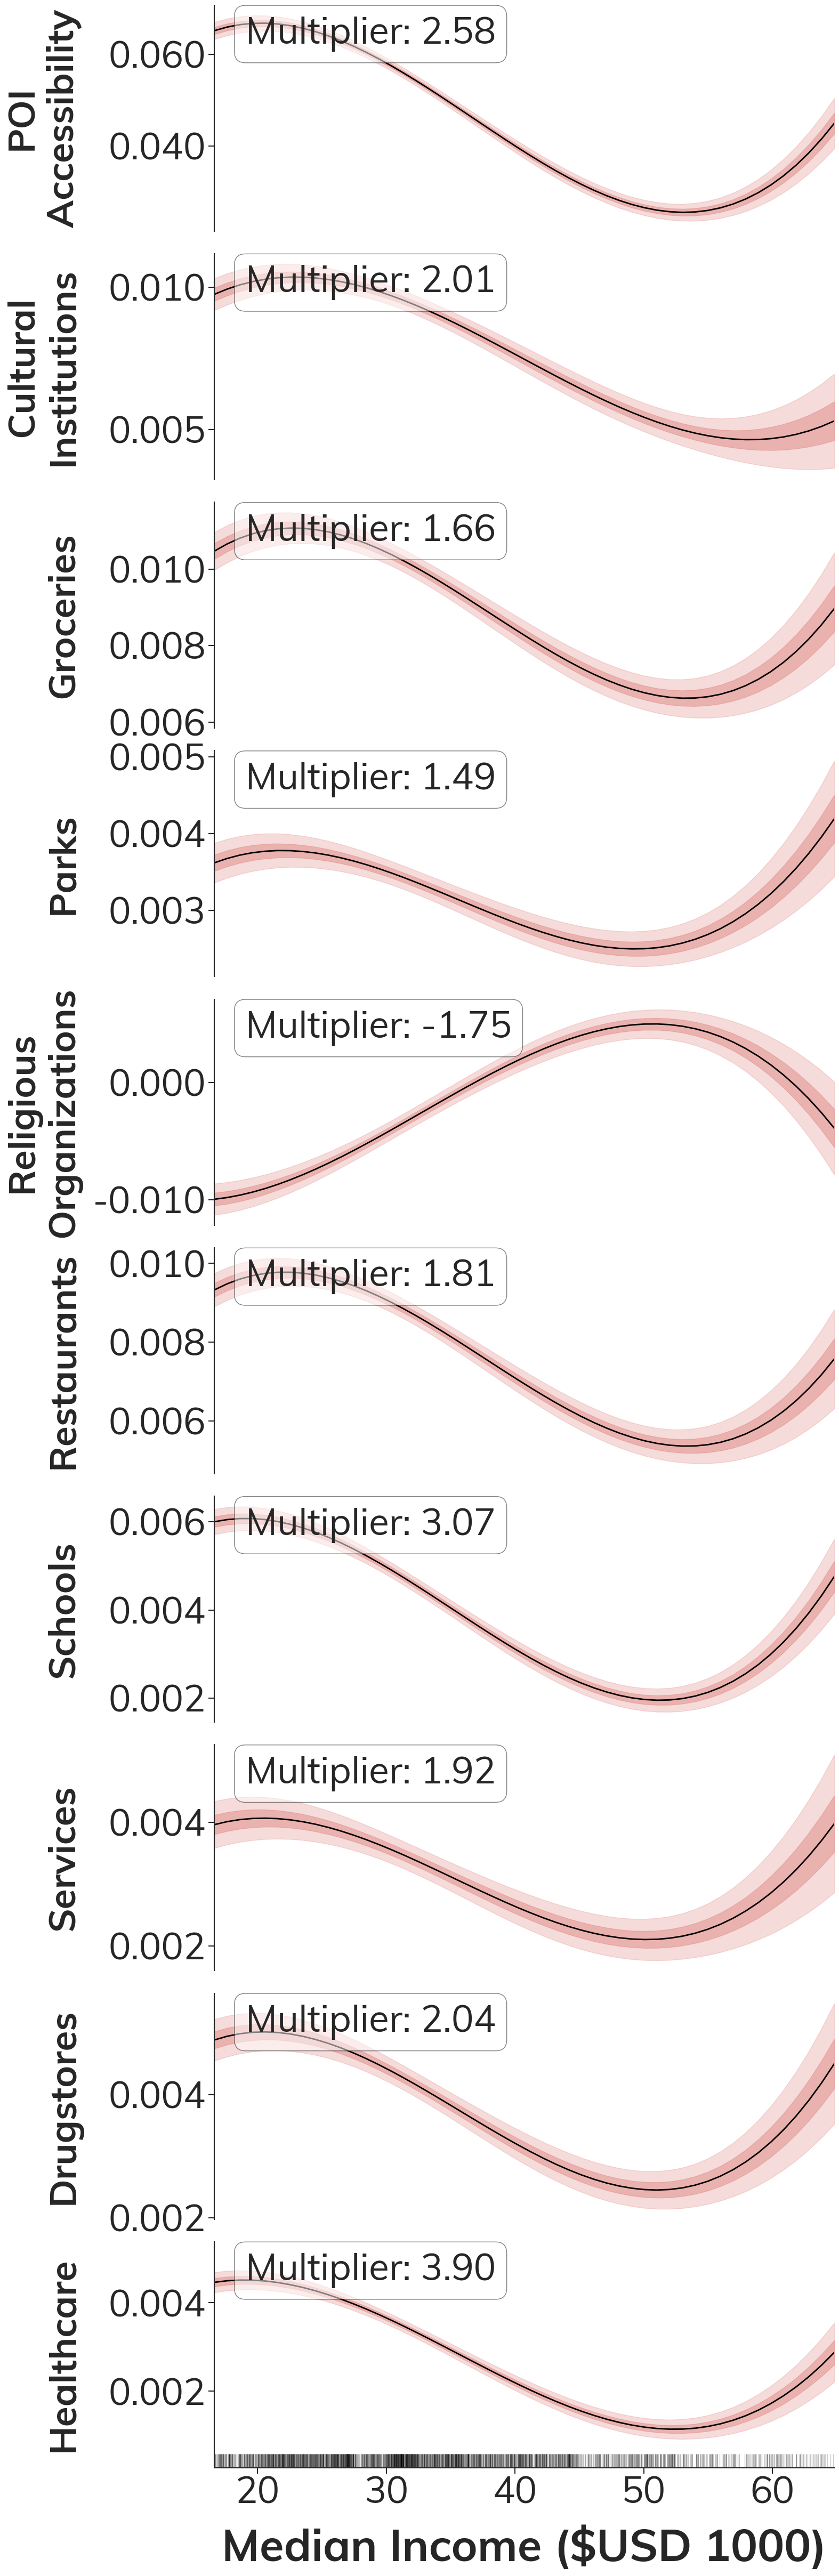

/var/folders/sl/b1w4bg0n63l4xh0kblz9m3br0000gp/T/ipykernel_47665/2059511858.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


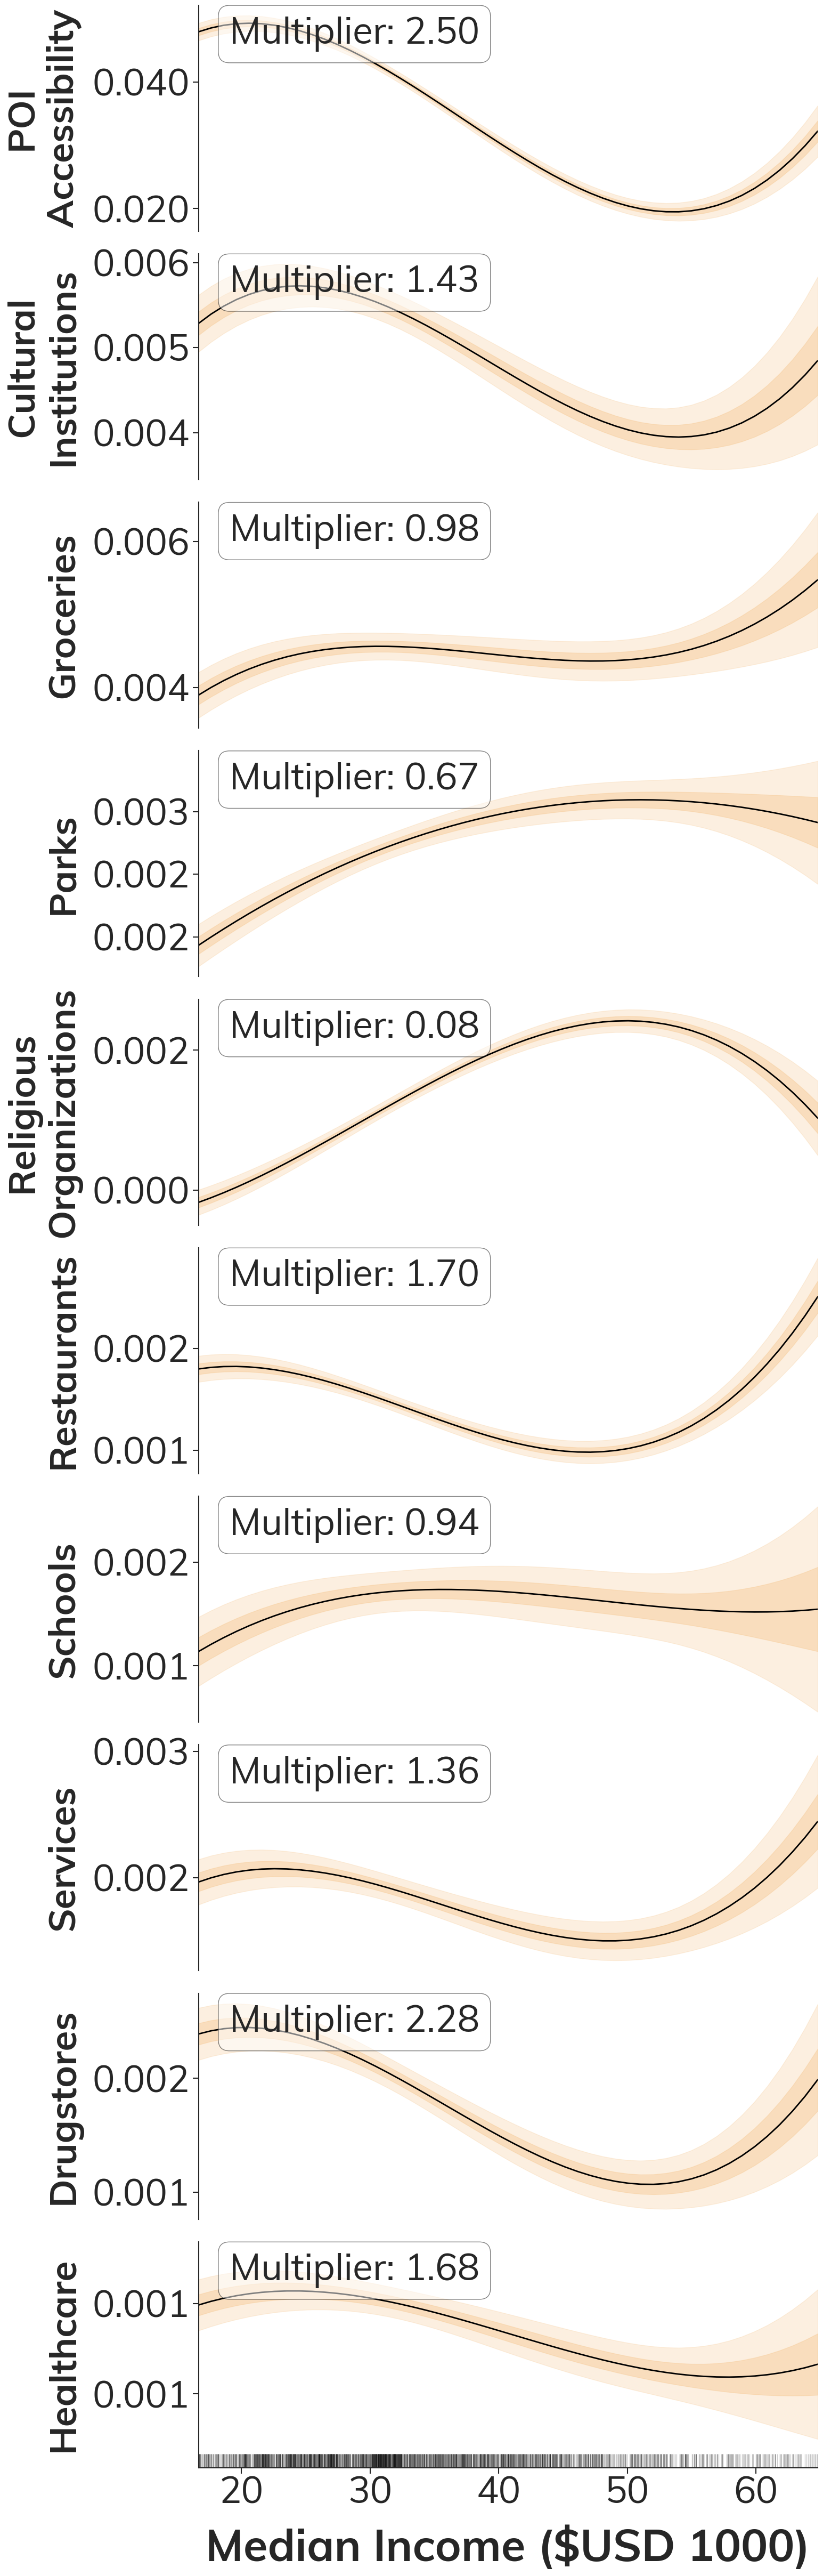

/var/folders/sl/b1w4bg0n63l4xh0kblz9m3br0000gp/T/ipykernel_47665/2059511858.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


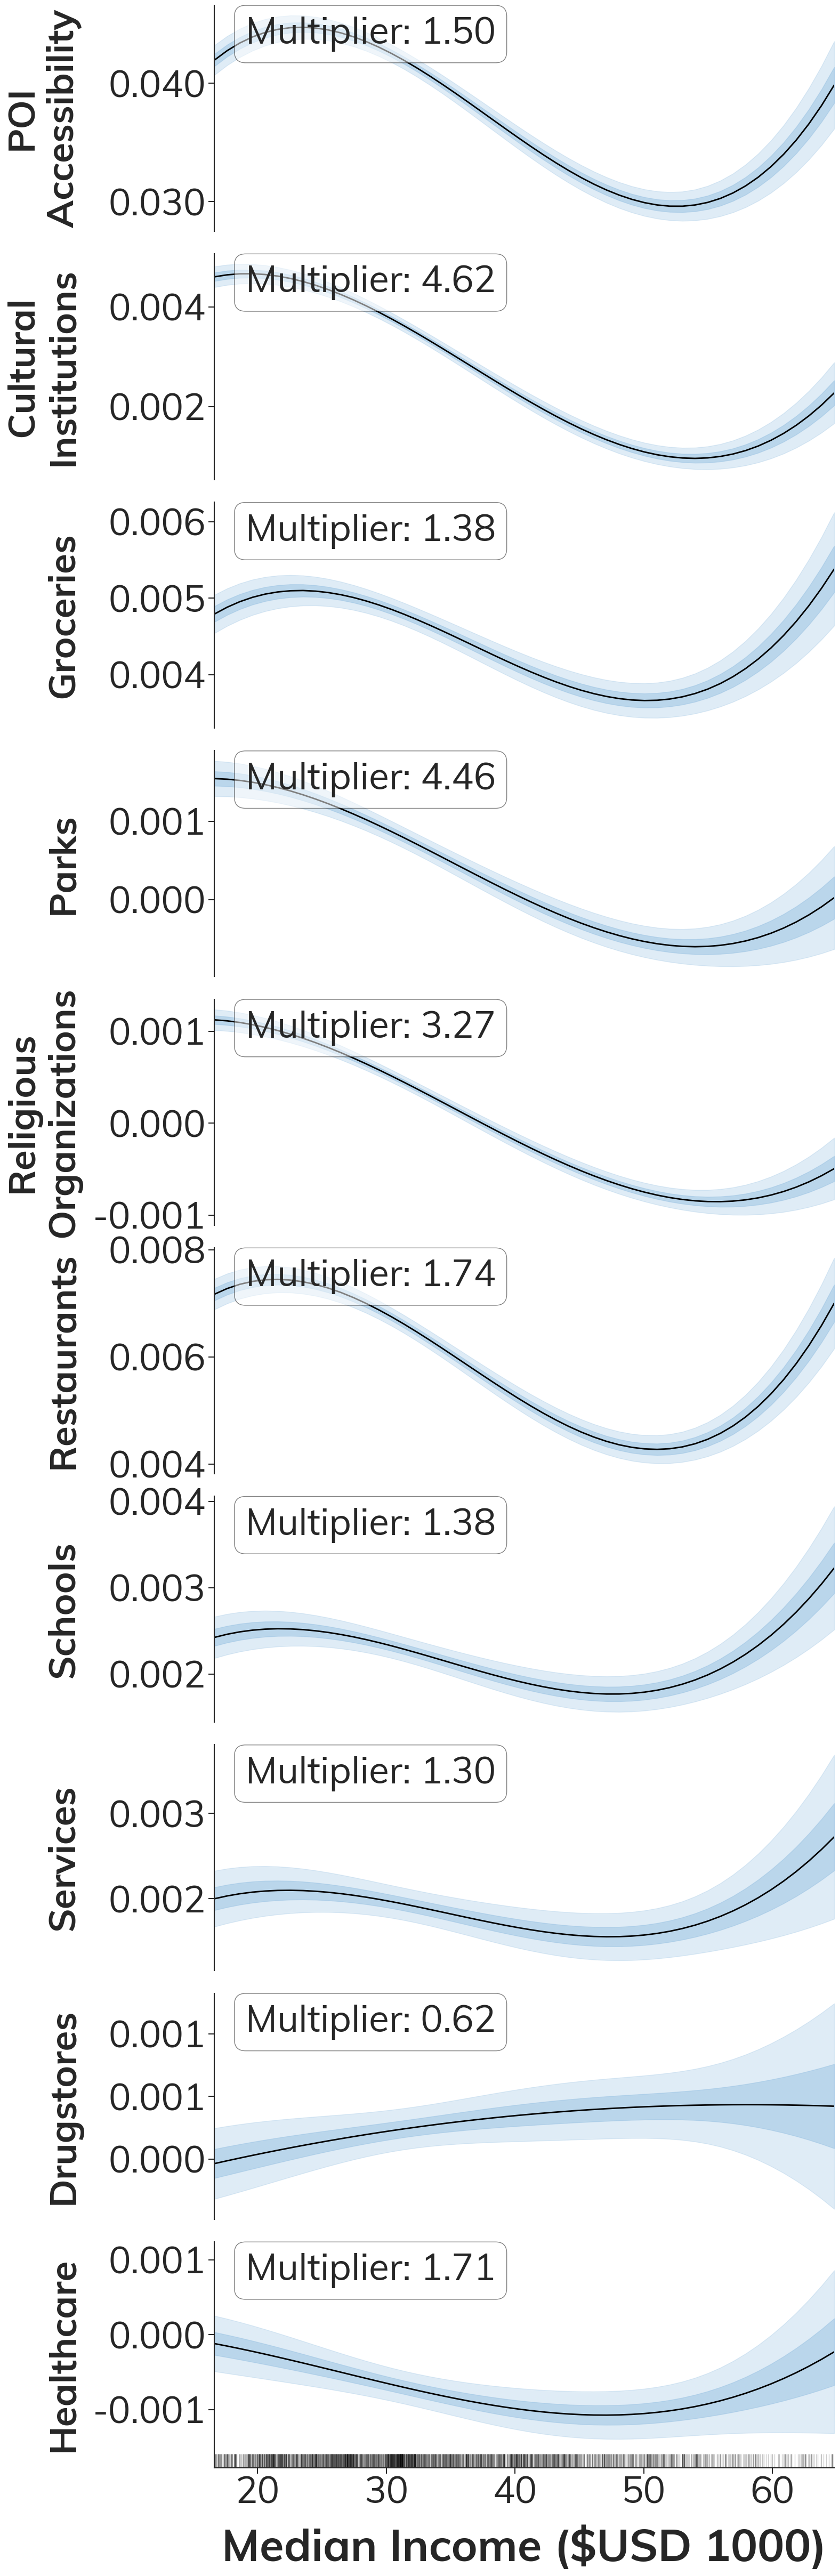

In [73]:
for target_col, df_perturb in zip(target_cols, all_df_perturb):
    domain = target_col.split()[0]  # 'General', 'Physical', or 'Mental'
    # Create a single Figure
    fig = plt.figure(figsize=(15, 60))  # Adjust size as needed

    # Create a 10x1 GridSpec (10 rows, 1 column)
    gs = gridspec.GridSpec(10, 1, hspace=0.1)  # hspace adjusts vertical spacing

    multiplier_dict = {}

    # Loop through each of your service columns (assumed to be 10 columns)
    for i, y_col in enumerate(services_columns[:-1]):
        # Create an Axes in the appropriate subplot cell:
        ax = fig.add_subplot(gs[i, 0])
        
        # Filter your DataFrame
        X_temp = df_perturb[['Median Income', y_col]].dropna()
        X = X_temp['Median Income'].values.reshape(-1, 1) 
        y = X_temp[y_col].values

        # Create polynomial features (degree=3) and fit OLS model
        polynomial_features = PolynomialFeatures(degree=3)
        X_poly = polynomial_features.fit_transform(X)
        model = sm.OLS(y, X_poly).fit()

        # Generate a smooth x-range and predictions for plotting
        x_range = np.linspace(X.min(), X.max(), 50).reshape(-1, 1)
        x_range_poly = polynomial_features.transform(x_range)
        predictions = model.get_prediction(x_range_poly)

        # Extract predicted values and confidence intervals
        pred_summary_90 = predictions.summary_frame(alpha=0.1)  # 90% CI
        pred_summary_50 = predictions.summary_frame(alpha=0.5)  # 50% CI
        predicted = pred_summary_90['mean']
        lower_ci_90 = pred_summary_90['mean_ci_lower']
        upper_ci_90 = pred_summary_90['mean_ci_upper']
        lower_ci_50 = pred_summary_50['mean_ci_lower']
        upper_ci_50 = pred_summary_50['mean_ci_upper']

        # Plot the regression line and CI fills
        sns.lineplot(ax=ax, x=x_range.flatten(), y=predicted, color='black', linewidth=2)
        colors = {'General': '#e18a85', 'Physical': '#f7cd9b', 'Mental':'#97c1e2'}

        ax.fill_between(x_range.flatten(), upper_ci_90, lower_ci_90,
                        color=colors[domain], alpha=0.3, label='90% CI')
        ax.fill_between(x_range.flatten(), upper_ci_50, lower_ci_50,
                        color=colors[domain], alpha=0.5, label='50% CI')

        # For the bottom subplot, add x-axis ticks and rugplot; for others remove x ticks.
        if i == len(services_columns[:-1]) - 1:
            ax.set_xlabel('Median Income ($USD 1000)', fontsize=60, labelpad=20, 
                        fontfamily='Muli', fontweight='bold')
            sns.rugplot(ax=ax, x=X_temp['Median Income'].sample(frac=0.1), 
                        height=0.06, color='black', alpha=0.2)

            # --- Rescale xticks: show 20000 as 20, 40000 as 40, etc ---
            ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x/1000)))
        else:
            ax.set_xticks([])
            ax.set_xlabel('')
            
        # Set y-axis label (service name) for every subplot
        ax.set_ylabel(y_col.replace(' ', '\n'), fontfamily='Muli', fontsize=50, fontweight='bold', labelpad=15)
        ax.set_xlim(X.min(), X.max())
        ax.tick_params(axis='both', labelsize=40, labelfontfamily='Muli')
        ax.grid(False)

        # Round y-axis ticks to 3 decimals
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))

        # --- Compute the multiplier for this feature ---
        x_10 = np.percentile(X, 10)
        x_90 = np.percentile(X, 90)
        
        x_10_poly = polynomial_features.transform([[x_10]])  # shape: (1, n_features)
        x_90_poly = polynomial_features.transform([[x_90]])
        
        pred_10_frame = model.get_prediction(x_10_poly).summary_frame(alpha=0.1)
        pred_10 = pred_10_frame['mean'].iloc[0]
        pred_10_lower_90 = pred_10_frame['mean_ci_lower'].iloc[0]
        pred_10_upper_90 = pred_10_frame['mean_ci_upper'].iloc[0]

        pred_90_frame = model.get_prediction(x_90_poly).summary_frame(alpha=0.1)
        pred_90 = pred_90_frame['mean'].iloc[0]
        pred_90_lower_90 = pred_90_frame['mean_ci_lower'].iloc[0]
        pred_90_upper_90 = pred_90_frame['mean_ci_upper'].iloc[0]

        multiplier = (pred_10 - pred_90) / abs(pred_90) + 1 if pred_90 != 0 else np.nan
        
        multiplier_dict[y_col] = {
            'pred_10': pred_10,
            'pred_10_lower_90': pred_10_lower_90,
            'pred_10_upper_90': pred_10_upper_90,
            'pred_90': pred_90,
            'pred_90_lower_90': pred_90_lower_90,
            'pred_90_upper_90': pred_90_upper_90,
            'multiplier': multiplier
        }

        # Show the multiplier in the plot
        equation_text = f"Multiplier: {multiplier:.2f}"
        ax.text(
            0.05, 0.95,
            equation_text,
            transform=ax.transAxes,
            fontsize=50,
            fontfamily='Muli',
            verticalalignment='top',
            bbox=dict(
                facecolor='white',
                edgecolor='black',
                alpha=0.5,
                boxstyle='round'
            )
        )

        # Customize y-axis ticks and spine properties
        ax.tick_params(axis='y', which='major', length=8, width=1.5, direction='out', labelsize=50)
        ax.tick_params(axis='y', which='minor', length=4, width=1, direction='out', labelsize=50)
        ax.tick_params(axis='x', which='major', length=8, width=1.5, direction='out', labelsize=50)

        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if i != len(services_columns[:-1]) - 1:
            ax.spines['bottom'].set_visible(False)

    # Align y labels vertically across all subplots
    fig.align_ylabels(fig.axes)

    plt.tight_layout()
    plt.savefig(f'../figures/{domain}_multiplier.pdf', dpi=300, bbox_inches='tight')
    plt.show()

    # Combine multipliers
    arithmetic_mean_multiplier = np.nanmean([d['multiplier'] for d in multiplier_dict.values()])

    valid_multipliers = [d['multiplier'] for d in multiplier_dict.values() if d['multiplier'] > 0]
    if valid_multipliers:
        geometric_mean_multiplier = np.exp(np.mean(np.log(valid_multipliers)))
    else:
        geometric_mean_multiplier = np.nan



### State multiplier 

In [75]:
general_mult = pd.read_parquet('../data/general_multiplier_per_capita.parquet')
physical_mult = pd.read_parquet('../data/physical_multiplier_per_capita.parquet')
mental_mult = pd.read_parquet('../data/mental_multiplier_per_capita.parquet')

all_df_mult = [general_mult, physical_mult, mental_mult]

/var/folders/sl/b1w4bg0n63l4xh0kblz9m3br0000gp/T/ipykernel_47665/798031100.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


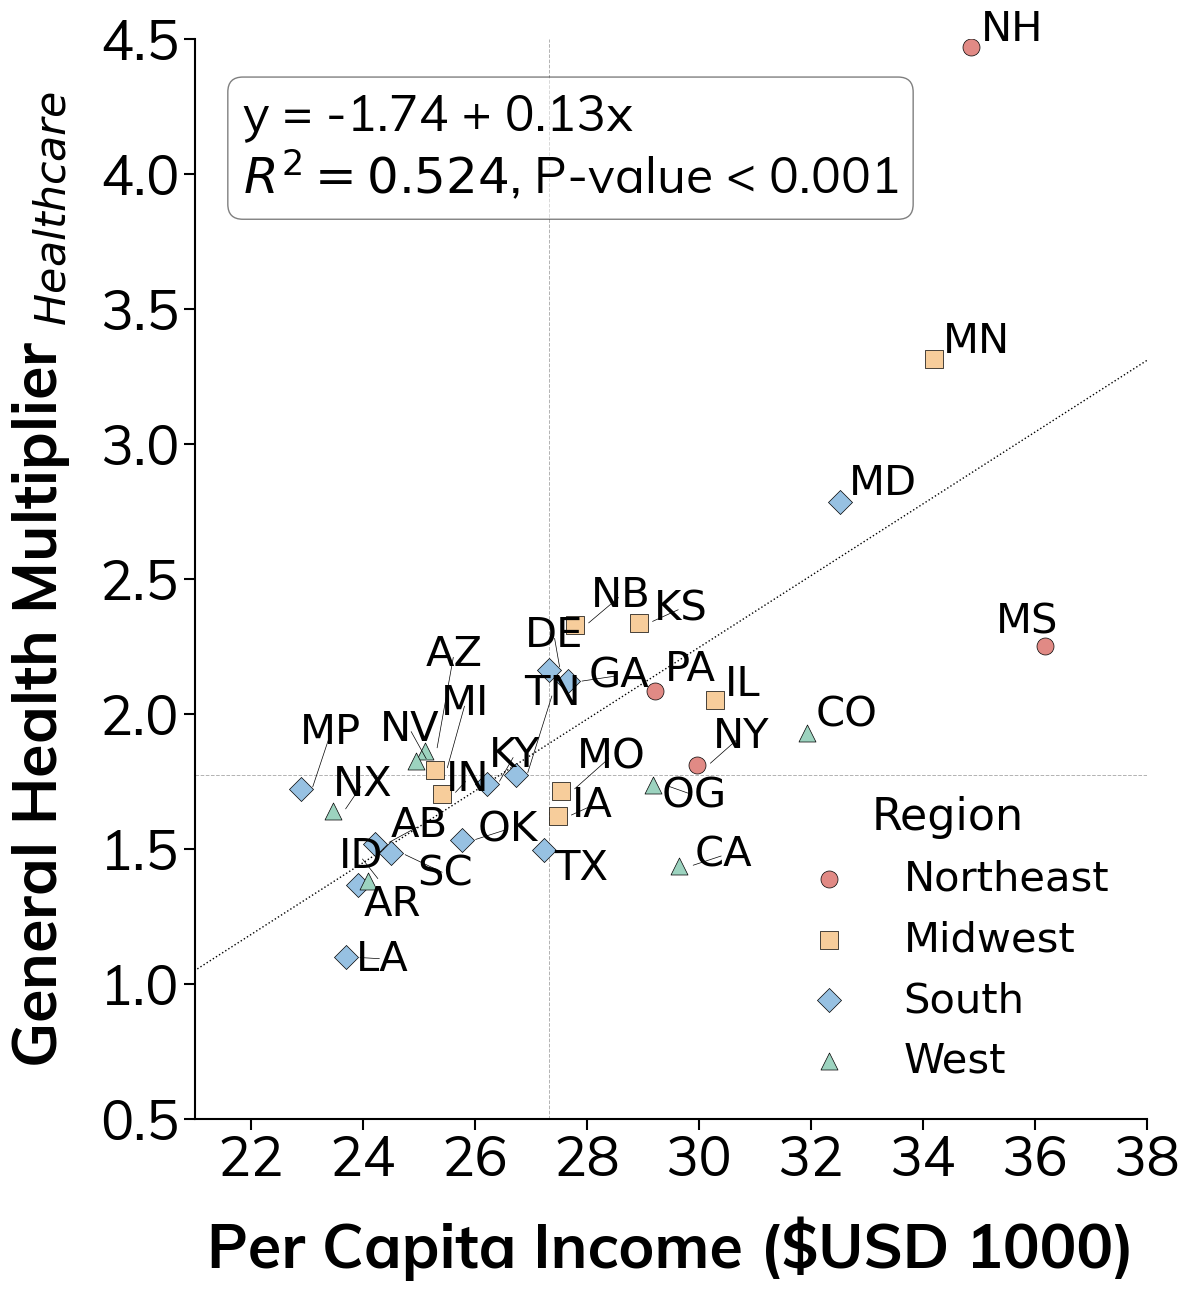

/var/folders/sl/b1w4bg0n63l4xh0kblz9m3br0000gp/T/ipykernel_47665/798031100.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


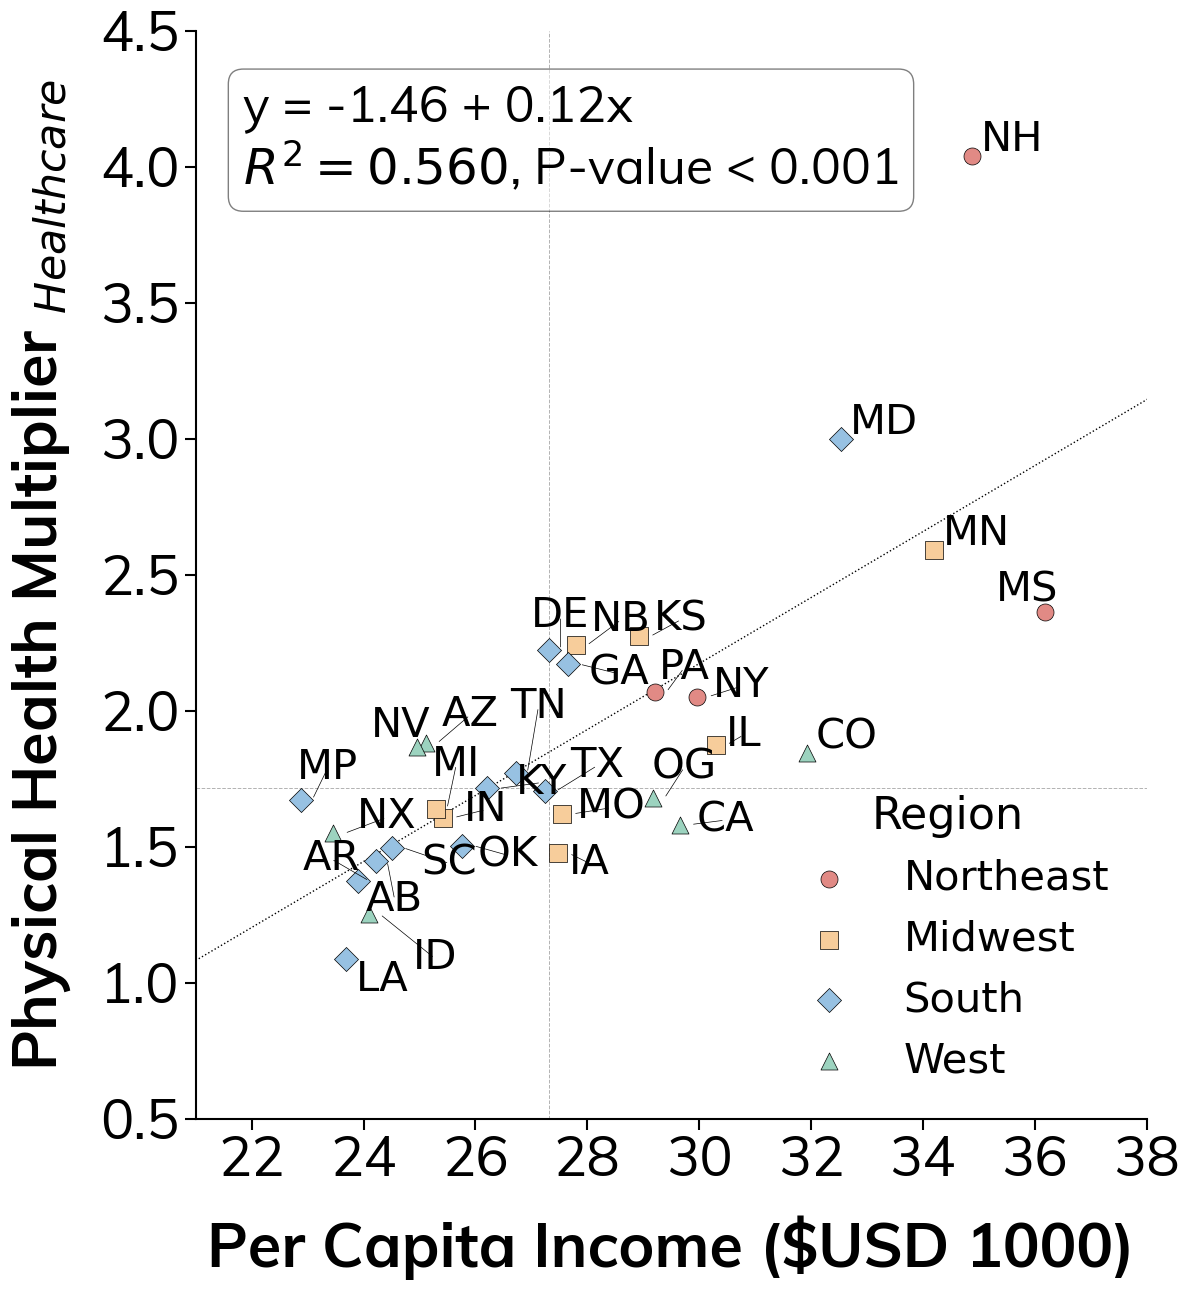

/var/folders/sl/b1w4bg0n63l4xh0kblz9m3br0000gp/T/ipykernel_47665/798031100.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


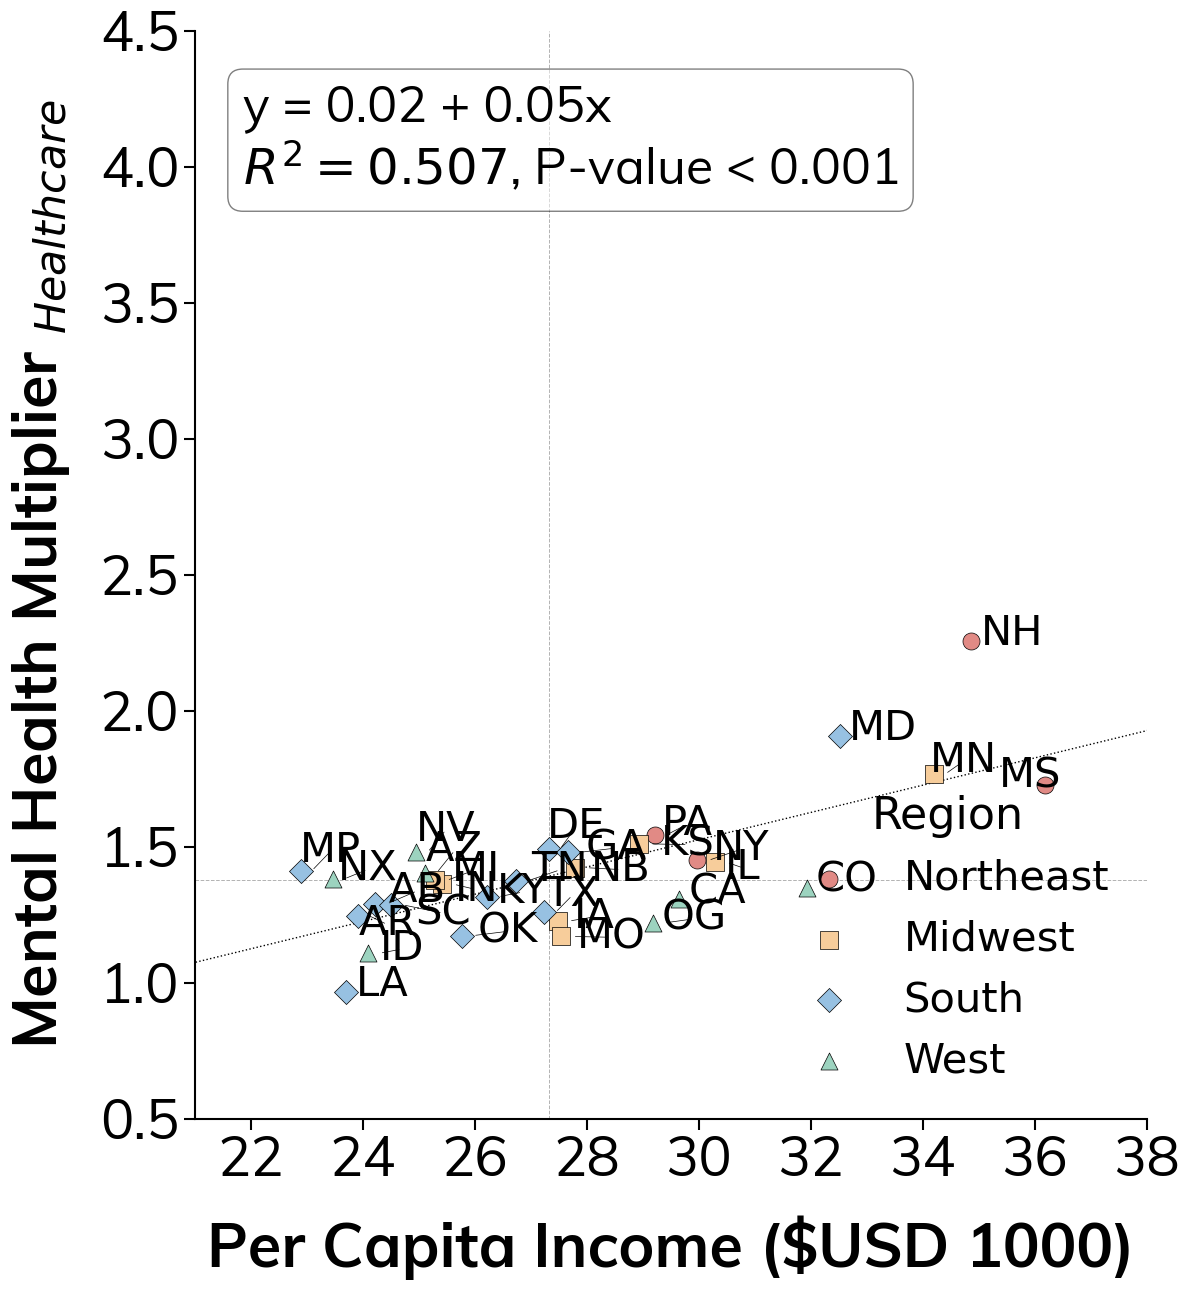

In [78]:
# Define markers for each region
region_markers = {
    'Northeast': 'o',  # Circle
    'Midwest': 's',    # Square
    'South': 'D',      # Diamond
    'West': '^'        # Triangle
}

for target_col, df_mult in zip(target_cols, all_df_mult):

    # Define color palette
    from adjustText import adjust_text
    domain = target_col.split()[0]  # 'General', 'Physical', or 'Mental'
    pastel_color_palette = ['#e18a85','#f7cd9b', '#97c1e2', '#9cd3bf']

    # Init the figure and axes
    plt.rcdefaults()
    fig, ax = plt.subplots(figsize=(12, 13))
    x = 'Income per capita'
    y = 'Geometric_Multiplier_Mean'

    # Plot each region with its corresponding marker
    for i, (region, marker) in enumerate(region_markers.items()):
        region_data = df_mult[df_mult['Region'] == region]
        ax.scatter(
            region_data[x],
            region_data[y],
            label=region,
            c=pastel_color_palette[i],  
            cmap=cmap,
            s=150,
            marker=marker,
            edgecolor='black',
            linewidth=0.5,
            alpha=1,
            zorder=3
        )

    # Create a legend for the regions
    ax.legend(
        title="Region",
        loc='lower right',             # Centers the legend on the plot
        frameon=False,
        fontsize=30,              # Font size for legend labels
        title_fontsize=32       # Font size for the legend title
    )


    # Add dotted lines for median references
    ax.axvline(df_mult[x].quantile(0.5), color='gray', linestyle='--', linewidth=0.7, alpha=0.6)
    ax.axhline(df_mult[y].quantile(0.5), color='gray', linestyle='--', linewidth=0.7, alpha=0.6)

    # Remove tick marks but keep labels
    ax.tick_params(axis='both', which='both', length=0)

    # ---------------------------
    # 1) Add labels for each point
    # ---------------------------
    texts = []
    for i, row in df_mult.iterrows():
        texts.append(
            ax.text(
                row[x]+0.2,
                row[y],
                str(row['STATE_NAME']),
                fontsize=30,
                zorder=5
            )
        )

    # Use adjust_text to avoid overlapping labels
    adjust_text(
        texts,
        ax=ax,
        expand_points=(5, 5),
        expand_text=(5, 5),
        arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
    )

    # ---------------------------
    # 2) Fit OLS regression line
    # ---------------------------
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_mult[x], df_mult[y])
    x_vals = np.linspace(0, 100, 100)
    y_vals = intercept + slope * x_vals

    ax.plot(x_vals, y_vals, color='black', linestyle=':', linewidth=1, label='OLS Regression', zorder=-1)

    # ---------------------------
    # 3) Annotate regression eqn & R²
    # ---------------------------
    equation_text = (
        f"y = {intercept:.2f} + {slope:.2f}x\n"
        f"$R^2 = {r_value**2:.3f}$, P-value {'< 0.001' if p_value.round(3) < 0.001 else p_value.round(3)}"
    )

    ax.text(
        0.05, 0.95,
        equation_text,
        transform=ax.transAxes,
        fontsize=36,
        color='black',
        fontfamily='Muli',
        verticalalignment='top',
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.5, boxstyle='round')
    )

    # Bold axis lines
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

    # Add tick markers
    ax.tick_params(axis='both', which='major', length=8, width=1.5, direction='out')
    ax.tick_params(axis='both', which='minor', length=4, width=1, direction='out')

    ax.set_ylim(0.5, 4.5)
    ax.set_xlim(21, 38)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.set_aspect(adjustable='datalim')  # 'box' ensures both axes are adjusted equally

    # ---------------------------
    # Final axis formatting
    # ---------------------------
    plt.xticks(fontsize=40, fontname="Muli", fontweight='regular')
    plt.yticks(fontsize=40, fontname="Muli", fontweight='regular')

    plt.xlabel('Per Capita Income ($USD 1000)', fontsize=44, labelpad=20, fontweight='bold', fontname="Muli")

    # Change the y-axis label to LaTeX math expression showing P25/P75
    plt.ylabel(
        f"{domain} Health Multiplier $_{{{y_col}}}$",
        fontsize=44,
        labelpad=20,
        fontweight='bold',
        fontname="Muli"
    )
    plt.tight_layout()

    # plt.savefig(f'../figures/{domain}_scatter_income_multiplier_{y_col}.png', dpi=600)
    plt.show()



### Association 

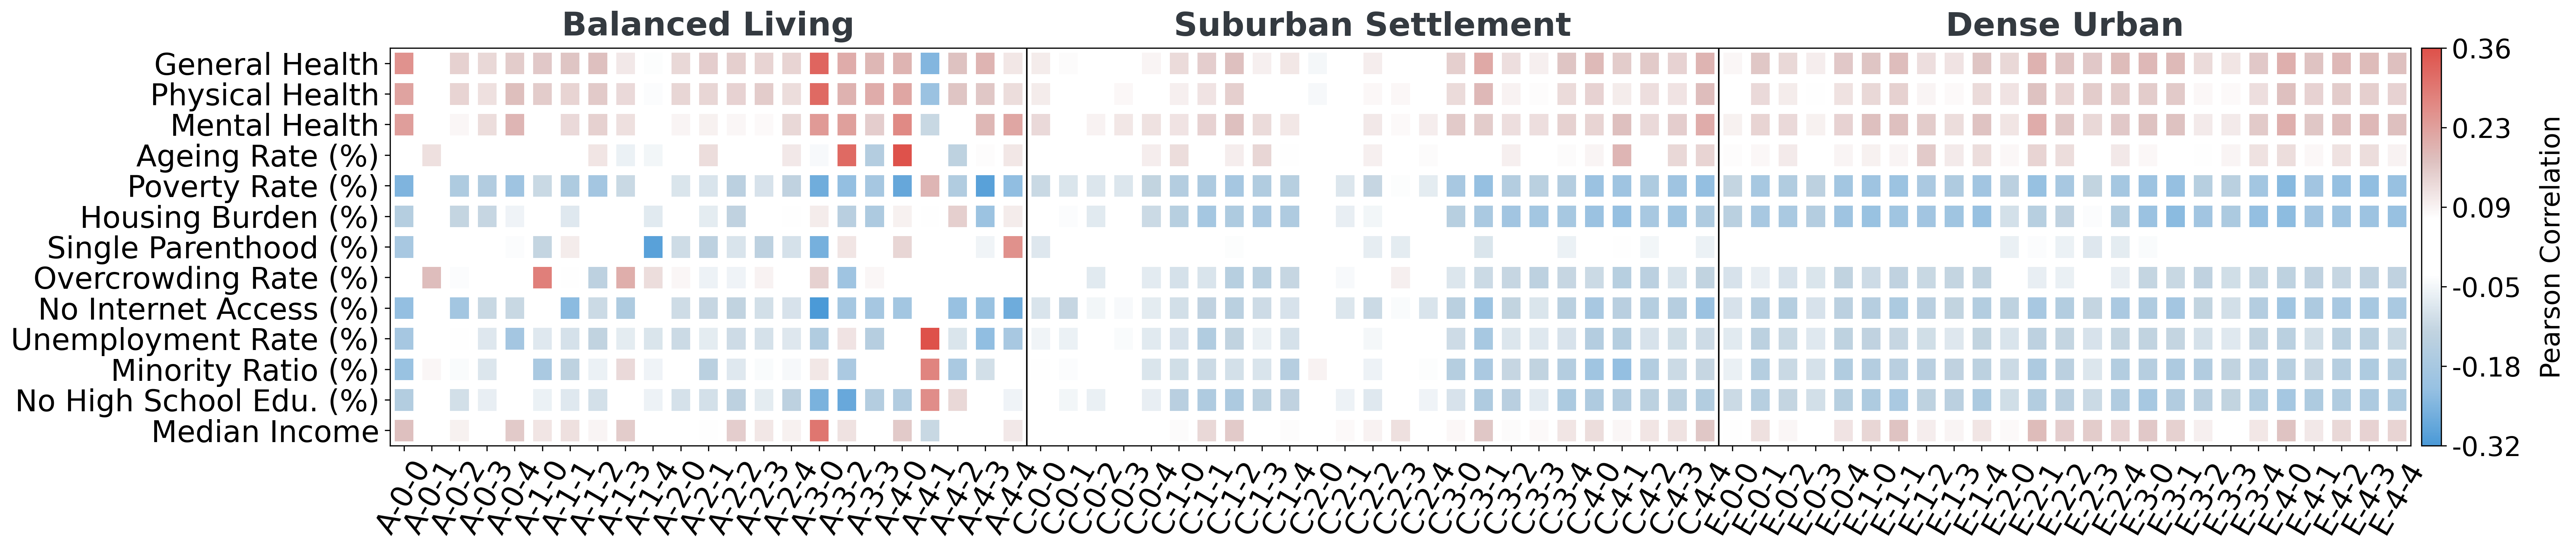

In [81]:
# --------------------- settings ---------------------
ALLOWED_LETTERS = list("ABCDE") # enforce A..E order
N_GROUPS = 4
TITLE = ""

# Colors

C_LOW_MID = "#4b9ad7"
C_LOW = "#97c1e2"
C_MID_LOW = "#c1d3e0"
C_MID_LOWEST = "#d0d8de"
C_MID = "#ffffff"
C_HIGH_LOWEST = "#ddcfce"
C_HIGH_LOW = "#dec2c1"
C_HIGH = "#e18a85"
C_HIGH_MID = "#de514a"

# Top ribbon relabels
LETTER_RENAME = {
    "A": "Balanced Living",
    "C": "Suburban Settlement",
    "E": "Dense Urban"
}
# ----------------------------------------------------

# 1) Load
association_df = pd.read_parquet('../data/motifs_association.parquet')
df = association_df  # replace with pd.read_csv("test.csv") if file-based

# Drop junk
for junk in ["Unnamed: 0", "index"]:
    if junk in df.columns:
        del df[junk]

if "Column" not in df.columns:
    raise ValueError("Expected a 'Column' field representing variable names.")

# 2) Detect pattern columns
pat = re.compile(r"^([A-Ea-e])-(\d+)-(\d+)$")
pattern_cols = [c for c in df.columns if pat.match(str(c)) and pat.match(c).group(1).upper() in ALLOWED_LETTERS]
if not pattern_cols:
    raise ValueError("No pattern columns like 'A-2-3'..'E-2-3' found.")

# 3) Sort patterns
def sort_key(p):
    m = pat.match(p)
    L = m.group(1).upper()
    n1, n2 = int(m.group(2)), int(m.group(3))
    return (ALLOWED_LETTERS.index(L), n1, n2)

pattern_cols = sorted(pattern_cols, key=sort_key)

# 4) Matrix
mat = df.set_index("Column")[pattern_cols].copy()

# 5) Cluster rows
row_order = np.arange(mat.shape[0])


mat = mat.iloc[row_order, :]
row_names = list(mat.index)

# Block ranges
blocks = []

# 6) Colormap
cmap = mpl.colors.LinearSegmentedColormap.from_list("custom3", [C_LOW_MID, C_LOW, C_MID_LOW, C_MID, C_MID, C_HIGH_LOW, C_HIGH, C_HIGH_MID])
vmin, vmax = np.nanmin(mat.values), np.nanmax(mat.values)

# 7) Figure
nrows, ncols = mat.shape
fig_w = max(12, min(28, 0.35 * ncols + 8))
fig_h = max(8,  min(24, 0.35 * nrows + 4))
fig, ax = plt.subplots(figsize=(fig_w, 5), dpi=300)

# 8) Heatmap
im = ax.imshow(mat.values, aspect="auto", cmap=cmap, vmin=vmin, vmax=vmax, interpolation="nearest")

# Grid
ax.set_xticks(np.arange(ncols))
ax.set_yticks(np.arange(nrows))
ax.set_xticks(np.arange(-0.5, ncols, 1), minor=True)
ax.set_yticks(np.arange(-0.5, nrows, 1), minor=True)
ax.grid(which="minor", color="white", linewidth=6)
ax.tick_params(which="minor", length=0)

# Labels
ax.set_xticklabels(mat.columns, fontsize=20, rotation=60, ha="center")
ax.set_yticklabels(row_names, fontsize=20)
plt.subplots_adjust(left=0.27, right=0.98, top=0.92, bottom=0.18)


# 10) Top ribbon with bigger labels + vertical separators
letters = [pat.match(p).group(1).upper() for p in mat.columns]
spans = []
s = 0
for i in range(1, len(letters)):
    if letters[i] != letters[i-1]:
        spans.append((letters[i-1], s, i))
        s = i
spans.append((letters[-1], s, len(letters)))

for L, s, e in spans:
    # ax.add_patch(Rectangle((s - 0.5, -1.25), e - s, 0.6,
    #                        facecolor="#f1f3f5", edgecolor="black", linewidth=1.2, zorder=3))
    label = LETTER_RENAME.get(L, L)
    ax.text((s + e - 1) / 2, -1.2, label, ha="center", va="center",
            fontsize=22, fontweight="bold", color="#343a40")  # bigger font

    # Add vertical line to demarcate column change
    if e < ncols:
        ax.vlines(e - 0.5, -0.5, nrows - 0.5, colors="black", linewidth=1.0)

# 11) Colorbar
from matplotlib.ticker import FormatStrFormatter

# 11) Colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.05, pad=0.005)
cbar.set_label("Pearson Correlation", rotation=90, labelpad=12, fontsize=18)
cbar.set_ticks(np.linspace(vmin, vmax, 6))

# Round to 2 decimals
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
cbar.ax.tick_params(labelsize=18)

# 12) Title
ax.set_title(TITLE, fontsize=16, pad=14, weight="bold")
# plt.savefig('../figures/motifs_association.pdf', dpi=300, bbox_inches = 'tight')
plt.show()


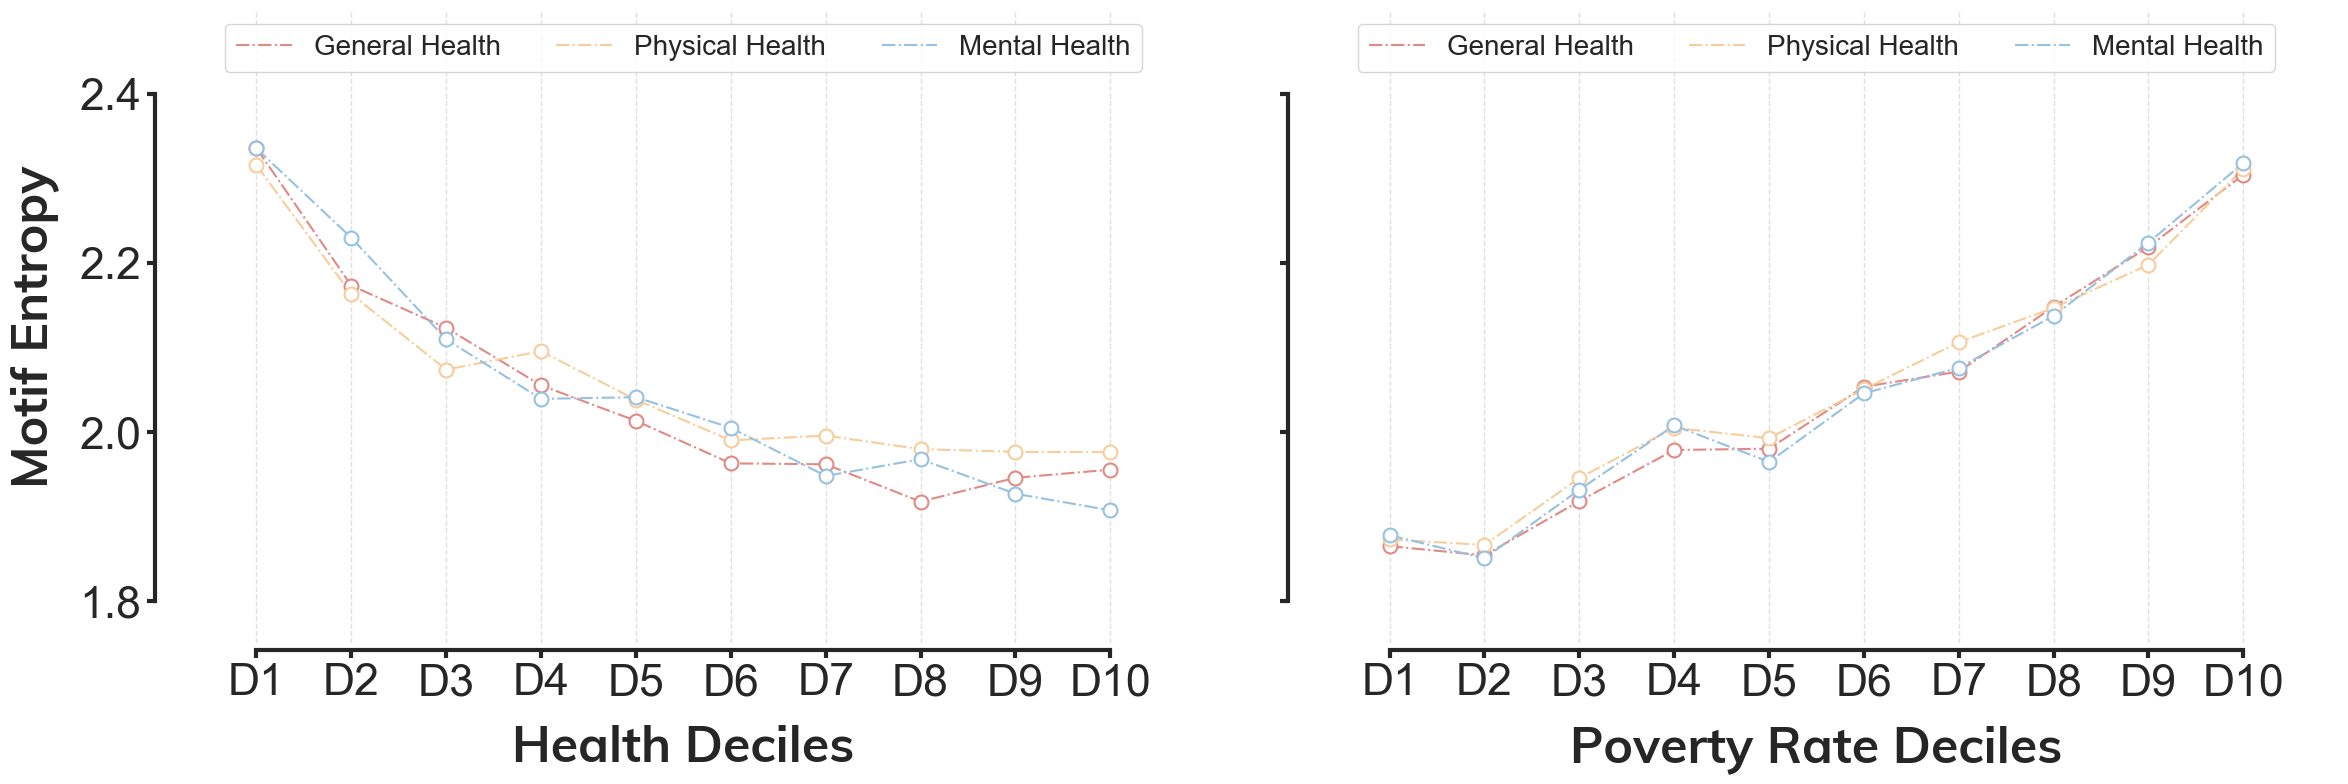

In [84]:
general_line_df = pd.read_parquet('../data/general_line_df.parquet')
physical_line_df = pd.read_parquet('../data/physical_line_df.parquet')
mental_line_df = pd.read_parquet('../data/mental_line_df.parquet')

# Create a figure with two subplots side by side, sharing y-axis
fig, axes = plt.subplots(1, 2, figsize=(24, 8), sharey=True)
fig.subplots_adjust(hspace=0)
sns.set_theme(style="ticks")

colors = ['#e18a85', '#f7cd9b', '#97c1e2']

# ------------------------
# First plot (Health Deciles)
# ------------------------
ax = axes[0] 

colors = ['#e18a85', '#f7cd9b', '#97c1e2']
y ='Health Entropy'
x = 'Health Decile'

# Scatter plot
sns.scatterplot(data = general_line_df, 
                x=general_line_df[x], 
                y=general_line_df[y], 
                color=colors[0], 
                marker="o", 
                facecolor='white', 
                ec=colors[0], 
                linewidth=1.5, 
                s=100, 
                zorder=3, ax=ax)

sns.scatterplot(data = physical_line_df, 
                x=physical_line_df[x], 
                y=physical_line_df[y], 
                color=colors[1], 
                marker="o", 
                facecolor='white', 
                ec=colors[1], 
                linewidth=1.5, 
                s=100, 
                zorder=3, ax=ax)

sns.scatterplot(data = mental_line_df, 
                x=mental_line_df[x], 
                y=mental_line_df[y], 
                color=colors[2], 
                marker="o", 
                facecolor='white', 
                ec=colors[2], 
                linewidth=1.5, 
                s=100, 
                zorder=3, ax=ax)

# Line plot
sns.lineplot(x=general_line_df[x], y=general_line_df[y], color=colors[0], linewidth=1.5, linestyle='dashdot', label='General Health', ax=ax)
sns.lineplot(x=physical_line_df[x], y=physical_line_df[y], color=colors[1], linewidth=1.5, linestyle='dashdot', label='Physical Health', ax=ax)
sns.lineplot(x=mental_line_df[x], y=mental_line_df[y], color=colors[2], linewidth=1.5, linestyle='dashdot', label='Mental Health', ax=ax)

ax.set_xlim(0, 11)
ax.set_xticks(range(1, 11))
ax.set_xticklabels([f'D{i}' for i in range(1, 11)], fontsize=32, fontname="Muli")
ax.set_xlabel("Health Deciles", fontname="Muli", fontsize=36, fontweight="bold", labelpad=15)
ax.set_ylabel("Motif Entropy", fontname="Muli", fontsize=36, fontweight="bold", labelpad=15)

ax.legend(loc='upper center', fontsize=20, ncol=3)

ax.tick_params(axis='both', labelsize=32, width=3)
for spine in ax.spines.values():
    spine.set_linewidth(3)

ax.tick_params(axis='both', labelsize=32)
for x_value in range(1, 11):
    ax.axvline(x=x_value, color='lightgrey', linestyle='--', linewidth=1.0, alpha=0.7, zorder=-2)

# ------------------------
# Second plot (Median Income Deciles)
# ------------------------
ax = axes[1]

target = 'Entropy'
target_x = 'Proportion of persons below 150 percent poverty threshold'

colors = ['#e18a85', '#f7cd9b', '#97c1e2']
y =f'{target_x} Entropy'
x = f'{target_x} decile'

# Scatter plot
sns.scatterplot(data = general_line_df, 
                x=general_line_df[x], 
                y=general_line_df[y], 
                color=colors[0], 
                marker="o", 
                facecolor='white', 
                ec=colors[0], 
                linewidth=1.5, 
                s=100, 
                zorder=3, ax=ax)

sns.scatterplot(data = physical_line_df, 
                x=physical_line_df[x], 
                y=physical_line_df[y], 
                color=colors[1], 
                marker="o", 
                facecolor='white', 
                ec=colors[1], 
                linewidth=1.5, 
                s=100, 
                zorder=3, ax=ax)

sns.scatterplot(data = mental_line_df, 
                x=mental_line_df[x], 
                y=mental_line_df[y], 
                color=colors[2], 
                marker="o", 
                facecolor='white', 
                ec=colors[2], 
                linewidth=1.5, 
                s=100, 
                zorder=3, ax=ax)


# Line plot
sns.lineplot(x=general_line_df[x], y=general_line_df[y], color=colors[0], linewidth=1.5, linestyle='dashdot', label='General Health', ax=ax)
sns.lineplot(x=physical_line_df[x], y=physical_line_df[y], color=colors[1], linewidth=1.5, linestyle='dashdot', label='Physical Health', ax=ax)
sns.lineplot(x=mental_line_df[x], y=mental_line_df[y], color=colors[2], linewidth=1.5, linestyle='dashdot', label='Mental Health', ax=ax)

ax.set_xlim(0, 11)
ax.set_xticks(range(1, 11))
ax.set_xticklabels([f'D{i}' for i in range(1, 11)], fontsize=32, fontname="Muli")
ax.set_xlabel("Poverty Rate Deciles", fontname="Muli", fontsize=36, fontweight="bold", labelpad=15)

ax.tick_params(axis='both', labelsize=32, width=3)
for spine in ax.spines.values():
    spine.set_linewidth(3)
ax.legend(loc='upper center', fontsize=20, ncol=3)

for x_value in range(1, 11):
    ax.axvline(x=x_value, color='lightgrey', linestyle='--', linewidth=1.0, alpha=0.7, zorder=-2)

ax.set_ylim(1.75,2.5)
# ------------------------
# Final touches
# ------------------------
sns.despine(offset=5, trim=True)
plt.tight_layout()
# plt.savefig('../figures/motif_entropy_pair.pdf', dpi=300, bbox_inches='tight')
plt.show()


/Users/winston/miniconda3/envs/largescale_health/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17907.
  res = hypotest_fun_out(*samples, **kwds)


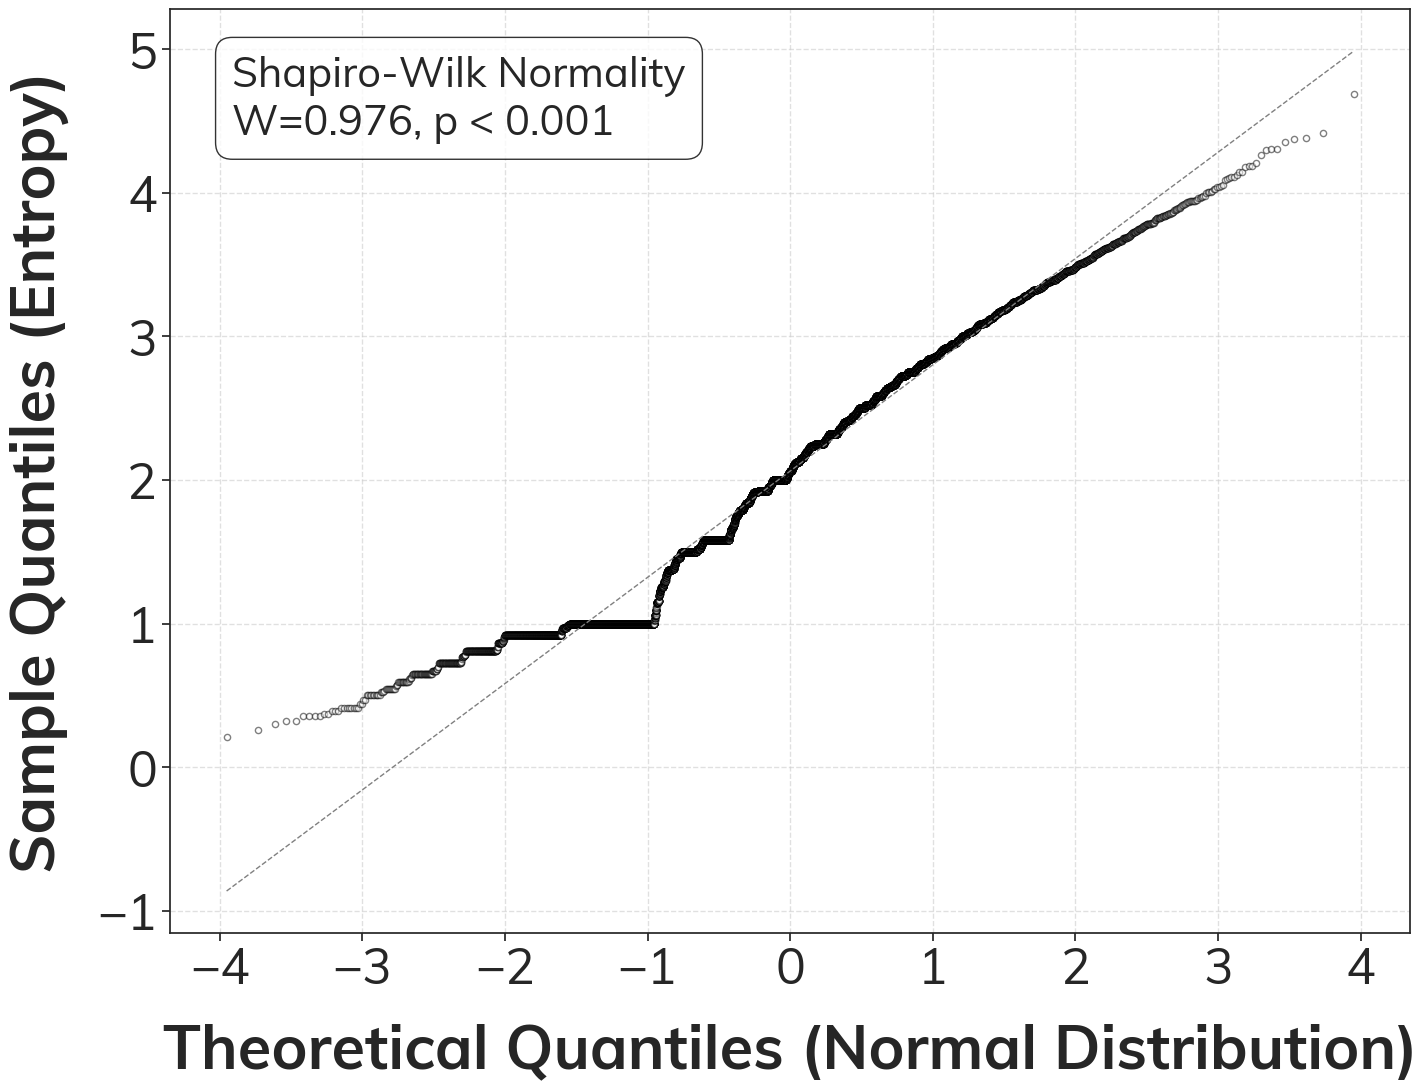

In [85]:
mpl.rc('font', family='Muli')
general_diversity_df = pd.read_parquet('../data/general_diversity_df.parquet')
# --- Normality tests ---
# Shapiro-Wilk
entropy_vals = general_diversity_df['Entropy'].dropna()
shapiro_stat, shapiro_p = stats.shapiro(entropy_vals)

# Kolmogorov-Smirnov (against normal with mean/std of data)
ks_stat, ks_p = stats.kstest(
    (entropy_vals - entropy_vals.mean()) / entropy_vals.std(ddof=0),
    'norm'
)

# Q-Q plot for 'Entropy'
plt.figure(figsize=(16, 12))
(osm, osr), (slope, intercept, r) = stats.probplot(entropy_vals, dist="norm")
plt.scatter(osm, osr, facecolor='white', edgecolor='black', s=20, alpha=0.5, label="Entropy")
plt.plot(osm, intercept + slope*osm, color='grey', linestyle='--', linewidth=1, label="Fit line")

# plt.title("Q-Q Plot of Entropy", fontsize=16, fontweight='bold')
plt.xlabel("Theoretical Quantiles (Normal Distribution)", fontname='Muli', fontsize=44, fontweight='bold', labelpad=20)
plt.ylabel("Sample Quantiles (Entropy)", fontsize=44, fontweight='bold', labelpad=20)
plt.grid(True, linestyle='--', alpha=0.6)

plt.text(
    0.05, 0.95,
    f"Shapiro-Wilk Normality\nW={shapiro_stat:.3f}, p < 0.001",
    transform=plt.gca().transAxes,
    fontsize=30,
    verticalalignment='top',
    horizontalalignment='left',
    bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="black", alpha=0.8)
)

plt.xticks(fontsize=36, fontname="Muli", fontweight='regular')
plt.yticks(fontsize=36, fontname="Muli", fontweight='regular')

# plt.savefig('../figures/qq_normality_entropy.pdf', dpi=300, bbox_inches='tight')
plt.show()

